# Last Away

In [1]:
import matplotlib
# matplotlib.use("Qt5Agg")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal, stats
import mat73
import re
from neurodsp.timefrequency import compute_wavelet_transform
from BCI2kReader import BCI2kReader as b2k
import os
import mne
from tabulate import tabulate
import IPython
import seaborn as sns
import scipy
import joblib

import statsmodels
from statsmodels import stats
from statsmodels.stats import multitest

# Import required code for visualizing example models
from fooof import FOOOF
from fooof.sim.gen import gen_power_spectrum
from fooof.sim.utils import set_random_seed
from fooof.plts.spectra import plot_spectra
from fooof.plts.annotate import plot_annotated_model
from neurodsp.utils import create_times
from neurodsp.plts.time_series import plot_time_series
from neurodsp.spectral import compute_spectrum, rotate_powerlaw
from neurodsp.plts.spectral import plot_power_spectra



In [102]:
sub_list = ['SLCH002', 'BJH016', 'BJH021', 'BJH025', 'LL10', 'LL12', 'LL13']

# ll_begin = sub_list.index('LL')
first_ll_sub = [subject for subject in sub_list if "LL" in subject][0]
first_ll_sub

'LL10'

In [113]:
def calculate_last_away_average(sub_list, roi):
    ghost_tfrs = []
    no_ghost_tfrs = []
    for subject in sub_list:

        # load data
        tmp_ghost_TFR = mne.time_frequency.read_tfrs(f"/home/brooke/pacman/preprocessing/{subject}/ieeg/last_away/{roi}_ghost-tfr.h5")
        tmp_no_ghost_TFR = mne.time_frequency.read_tfrs(f"/home/brooke/pacman/preprocessing/{subject}/ieeg/last_away/{roi}_noghost-tfr.h5")

        # get mean and append
        ghost_tfrs.append(tmp_ghost_TFR[0].data.mean(axis = 0).mean(axis = 0))
        no_ghost_tfrs.append(tmp_no_ghost_TFR[0].data.mean(axis = 0).mean(axis = 0))
        
    
    if any("LL" in subject for subject in sub_list):

        # get indicies of high/low samp rate subs
        first_ll_sub = [subject for subject in sub_list if "LL" in subject][0]
        ll_begin = sub_list.index(first_ll_sub)

        # high sampling rate
        washu_ghost_tfrs = np.asarray(ghost_tfrs[0:ll_begin])
        washu_ghost_tfrs_mean = washu_ghost_tfrs.mean(axis = 0)

        washu_no_ghost_tfrs = np.asarray(no_ghost_tfrs[0:ll_begin])
        washu_no_ghost_tfrs_mean = washu_no_ghost_tfrs.mean(axis = 0)

        # Low sampling rate
        ll_ghost_tfrs = np.asarray(ghost_tfrs[ll_begin:])
        ll_ghost_tfrs_mean = ll_ghost_tfrs.mean(axis = 0)

        ll_no_ghost_tfrs = np.asarray(no_ghost_tfrs[ll_begin:])
        ll_no_ghost_tfrs_mean = ll_no_ghost_tfrs.mean(axis = 0)

        # combine
        all_subs_ghost = np.stack((washu_ghost_tfrs_mean[:, ::2], ll_ghost_tfrs_mean[:, 0:2001]))
        all_subs_noghost = np.stack((washu_no_ghost_tfrs_mean[:, ::2], ll_no_ghost_tfrs_mean[:, 0:2001]))

        # mean
        all_subs_ghost_average = all_subs_ghost.mean(axis = 0)
        all_subs_noghost_average = all_subs_noghost.mean(axis = 0)
        
    else:
        
        # high sampling rate
        washu_ghost_tfrs = np.asarray(ghost_tfrs)
        washu_ghost_tfrs_mean = washu_ghost_tfrs.mean(axis = 0)

        washu_no_ghost_tfrs = np.asarray(no_ghost_tfrs)
        washu_no_ghost_tfrs_mean = washu_no_ghost_tfrs.mean(axis = 0)

        # mean
        all_subs_ghost_average = washu_ghost_tfrs_mean
        all_subs_noghost_average = washu_no_ghost_tfrs_mean     
        

    return all_subs_ghost_average, all_subs_noghost_average

def plot_allsub_averages(array_average, title, fname):
    plt.rcParams['figure.figsize'] = [45, 35]
    plt.rcParams.update({'font.size': 38})
    matplotlib.rcParams['font.serif'] = 'Times New Roman'
    matplotlib.rcParams['font.family'] = 'serif'

    freqs = np.logspace(start = np.log10(1), stop = np.log10(150), num = 80, base = 10, endpoint = True)
    yticks = np.linspace(np.min(freqs),np.max(freqs),len(freqs))
    yticks_labels = np.round(freqs, 1)

    fig, ax = plt.subplots()
    i = ax.imshow(array_average, cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin = -.15, vmax = .15)
    i2 = plt.axvline(x=0, color='black', linestyle='--')
    ax.set_yticks(yticks[::2])
    ax.set_yticklabels(yticks_labels[::2])
    bar = plt.colorbar(i)
    ax.set_title(title, fontsize=65, fontweight = "bold", pad=40)
    fig.savefig(fname, dpi=400)

## Hippocampus

In [68]:
sub_list = ['SLCH002', 'BJH016', 'BJH021', 'BJH025', 'LL10', 'LL12', 'LL13']

all_subs_ghost_average_hc, all_subs_noghost_average_hc = calculate_last_away_average(sub_list, 'hc')
    

Reading /home/brooke/pacman/preprocessing/SLCH002/ieeg/last_away/hc_ghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/SLCH002/ieeg/last_away/hc_noghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/BJH016/ieeg/last_away/hc_ghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/BJH016/ieeg/last_away/hc_noghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/BJH021/ieeg/last_away/hc_ghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/BJH021/ieeg/last_away/hc_noghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/BJH025/ieeg/last_away/hc_ghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/BJH025/ieeg/last_away/hc_noghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/LL10/ieeg/last_away/hc_ghost

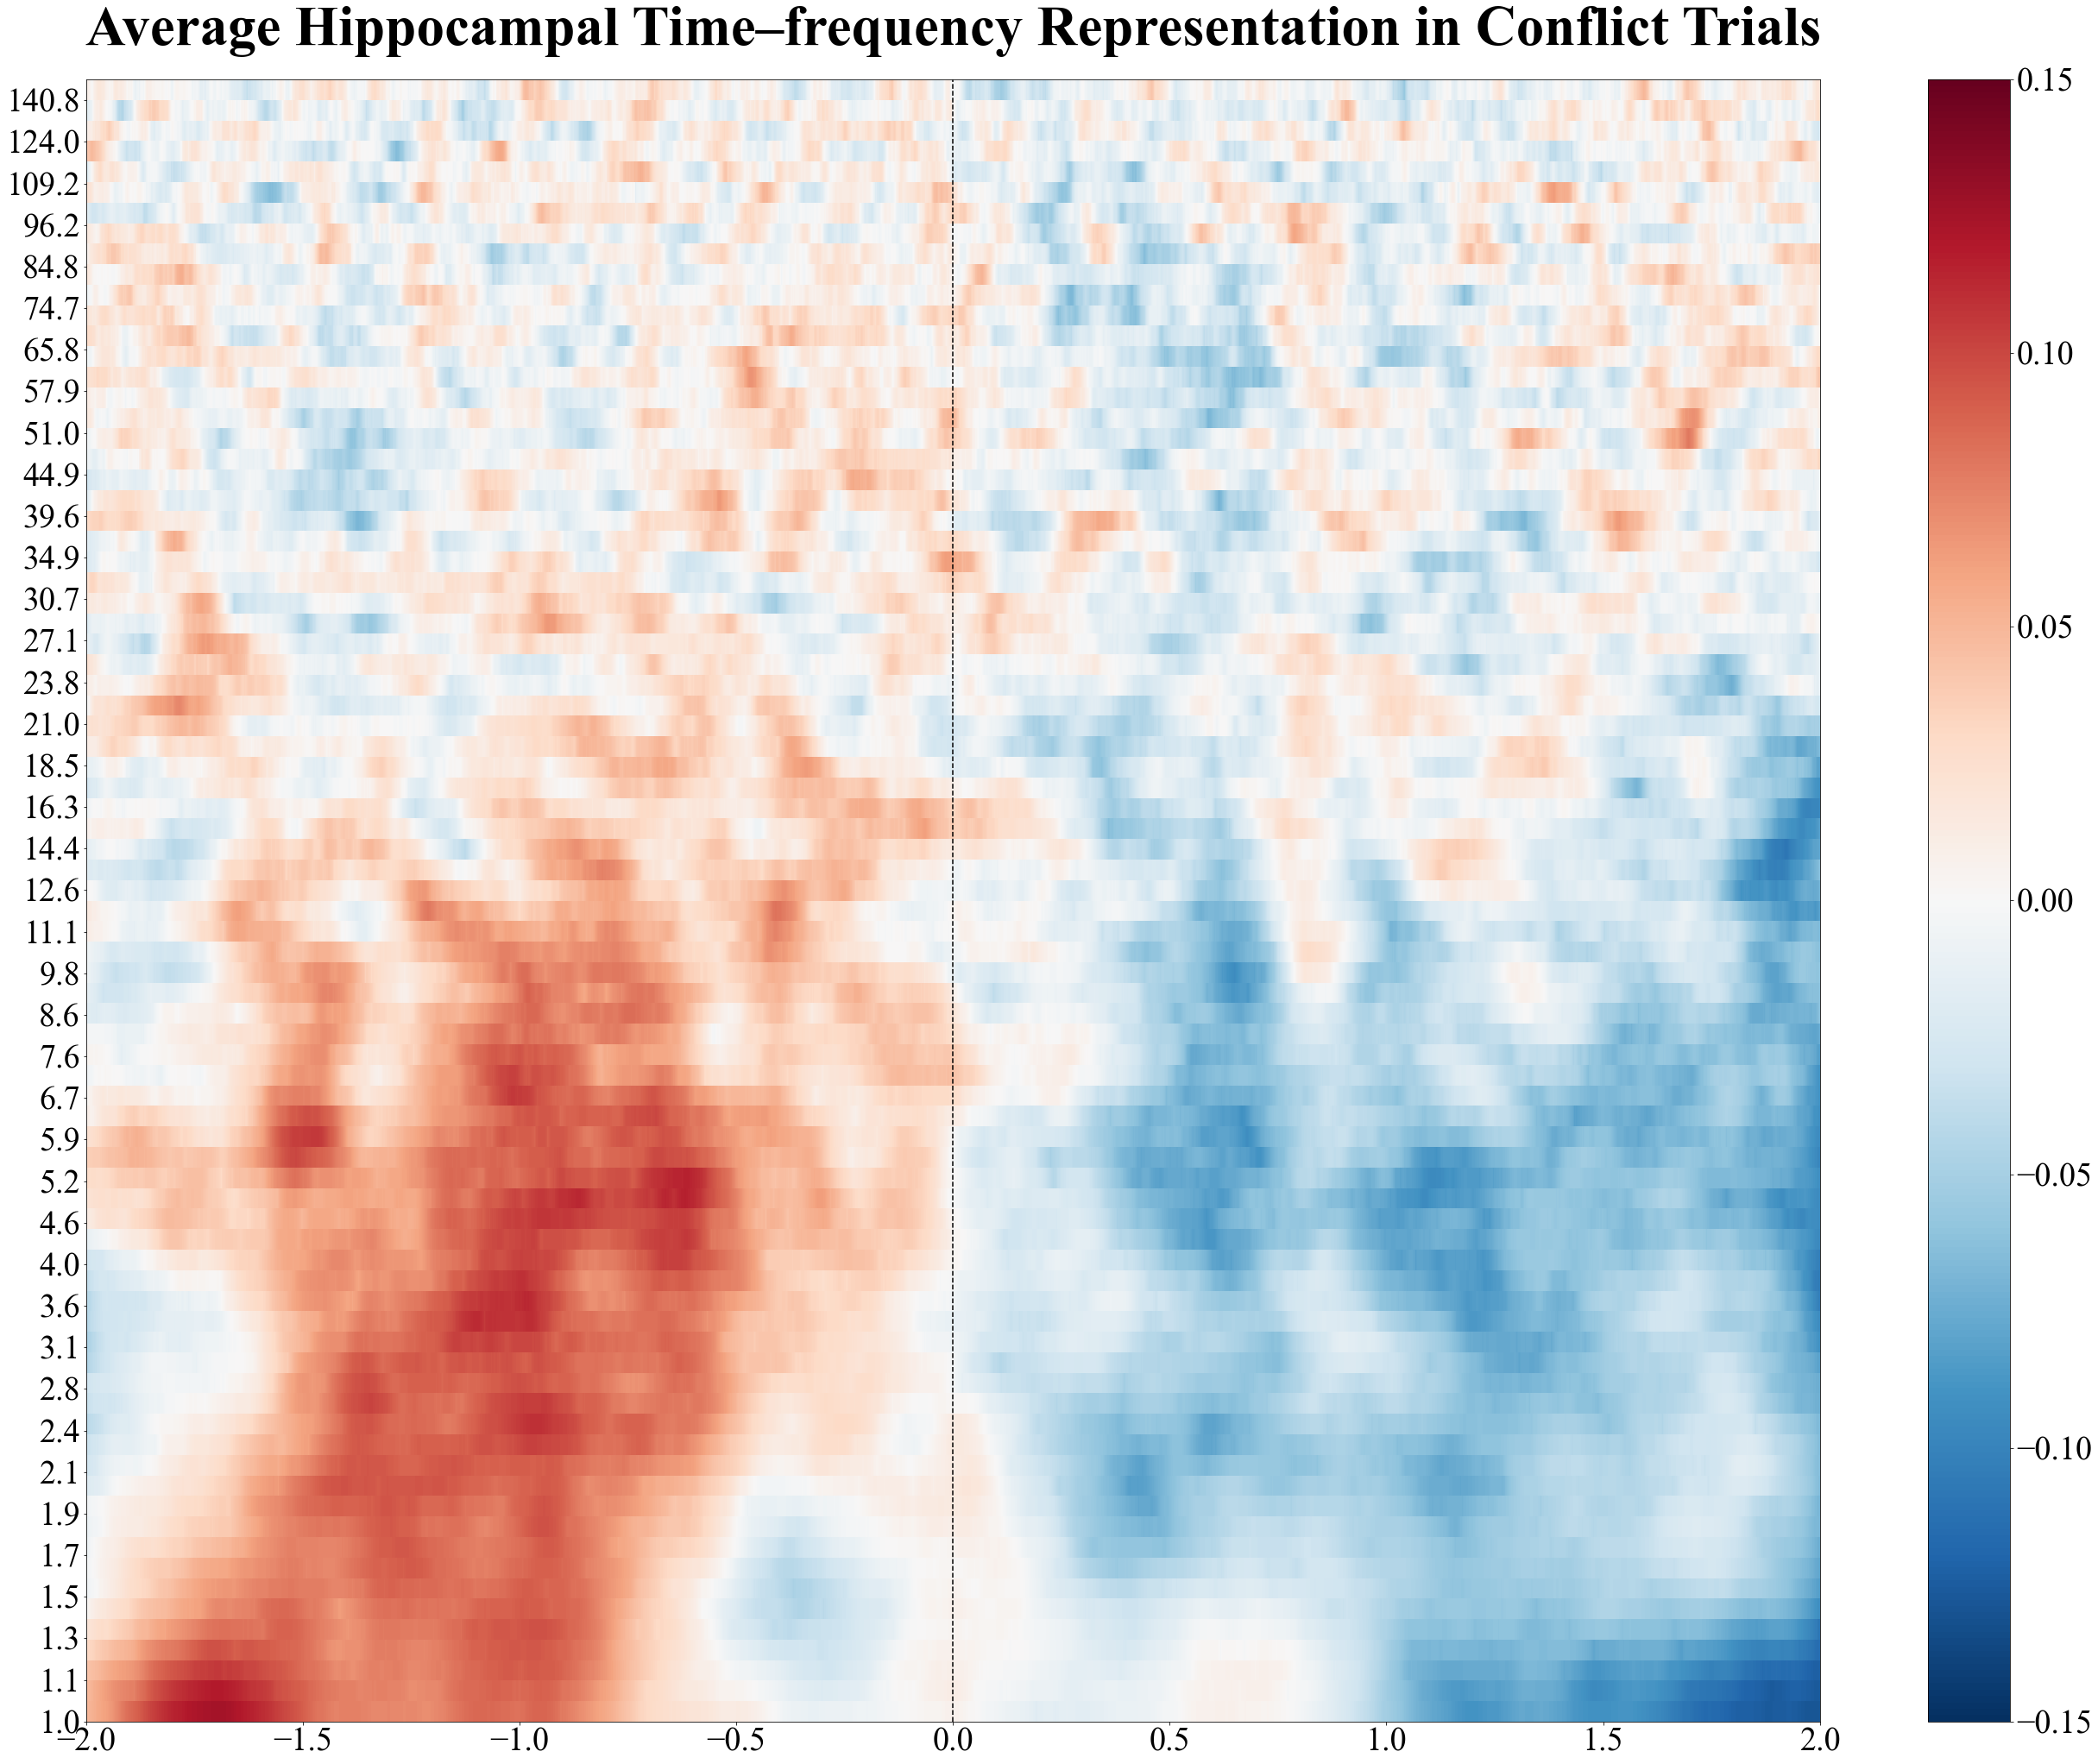

In [70]:
plot_allsub_averages(all_subs_ghost_average_hc, "Average Hippocampal Time–frequency Representation in Conflict Trials", 'average_hc_conflict_all_subs.png')

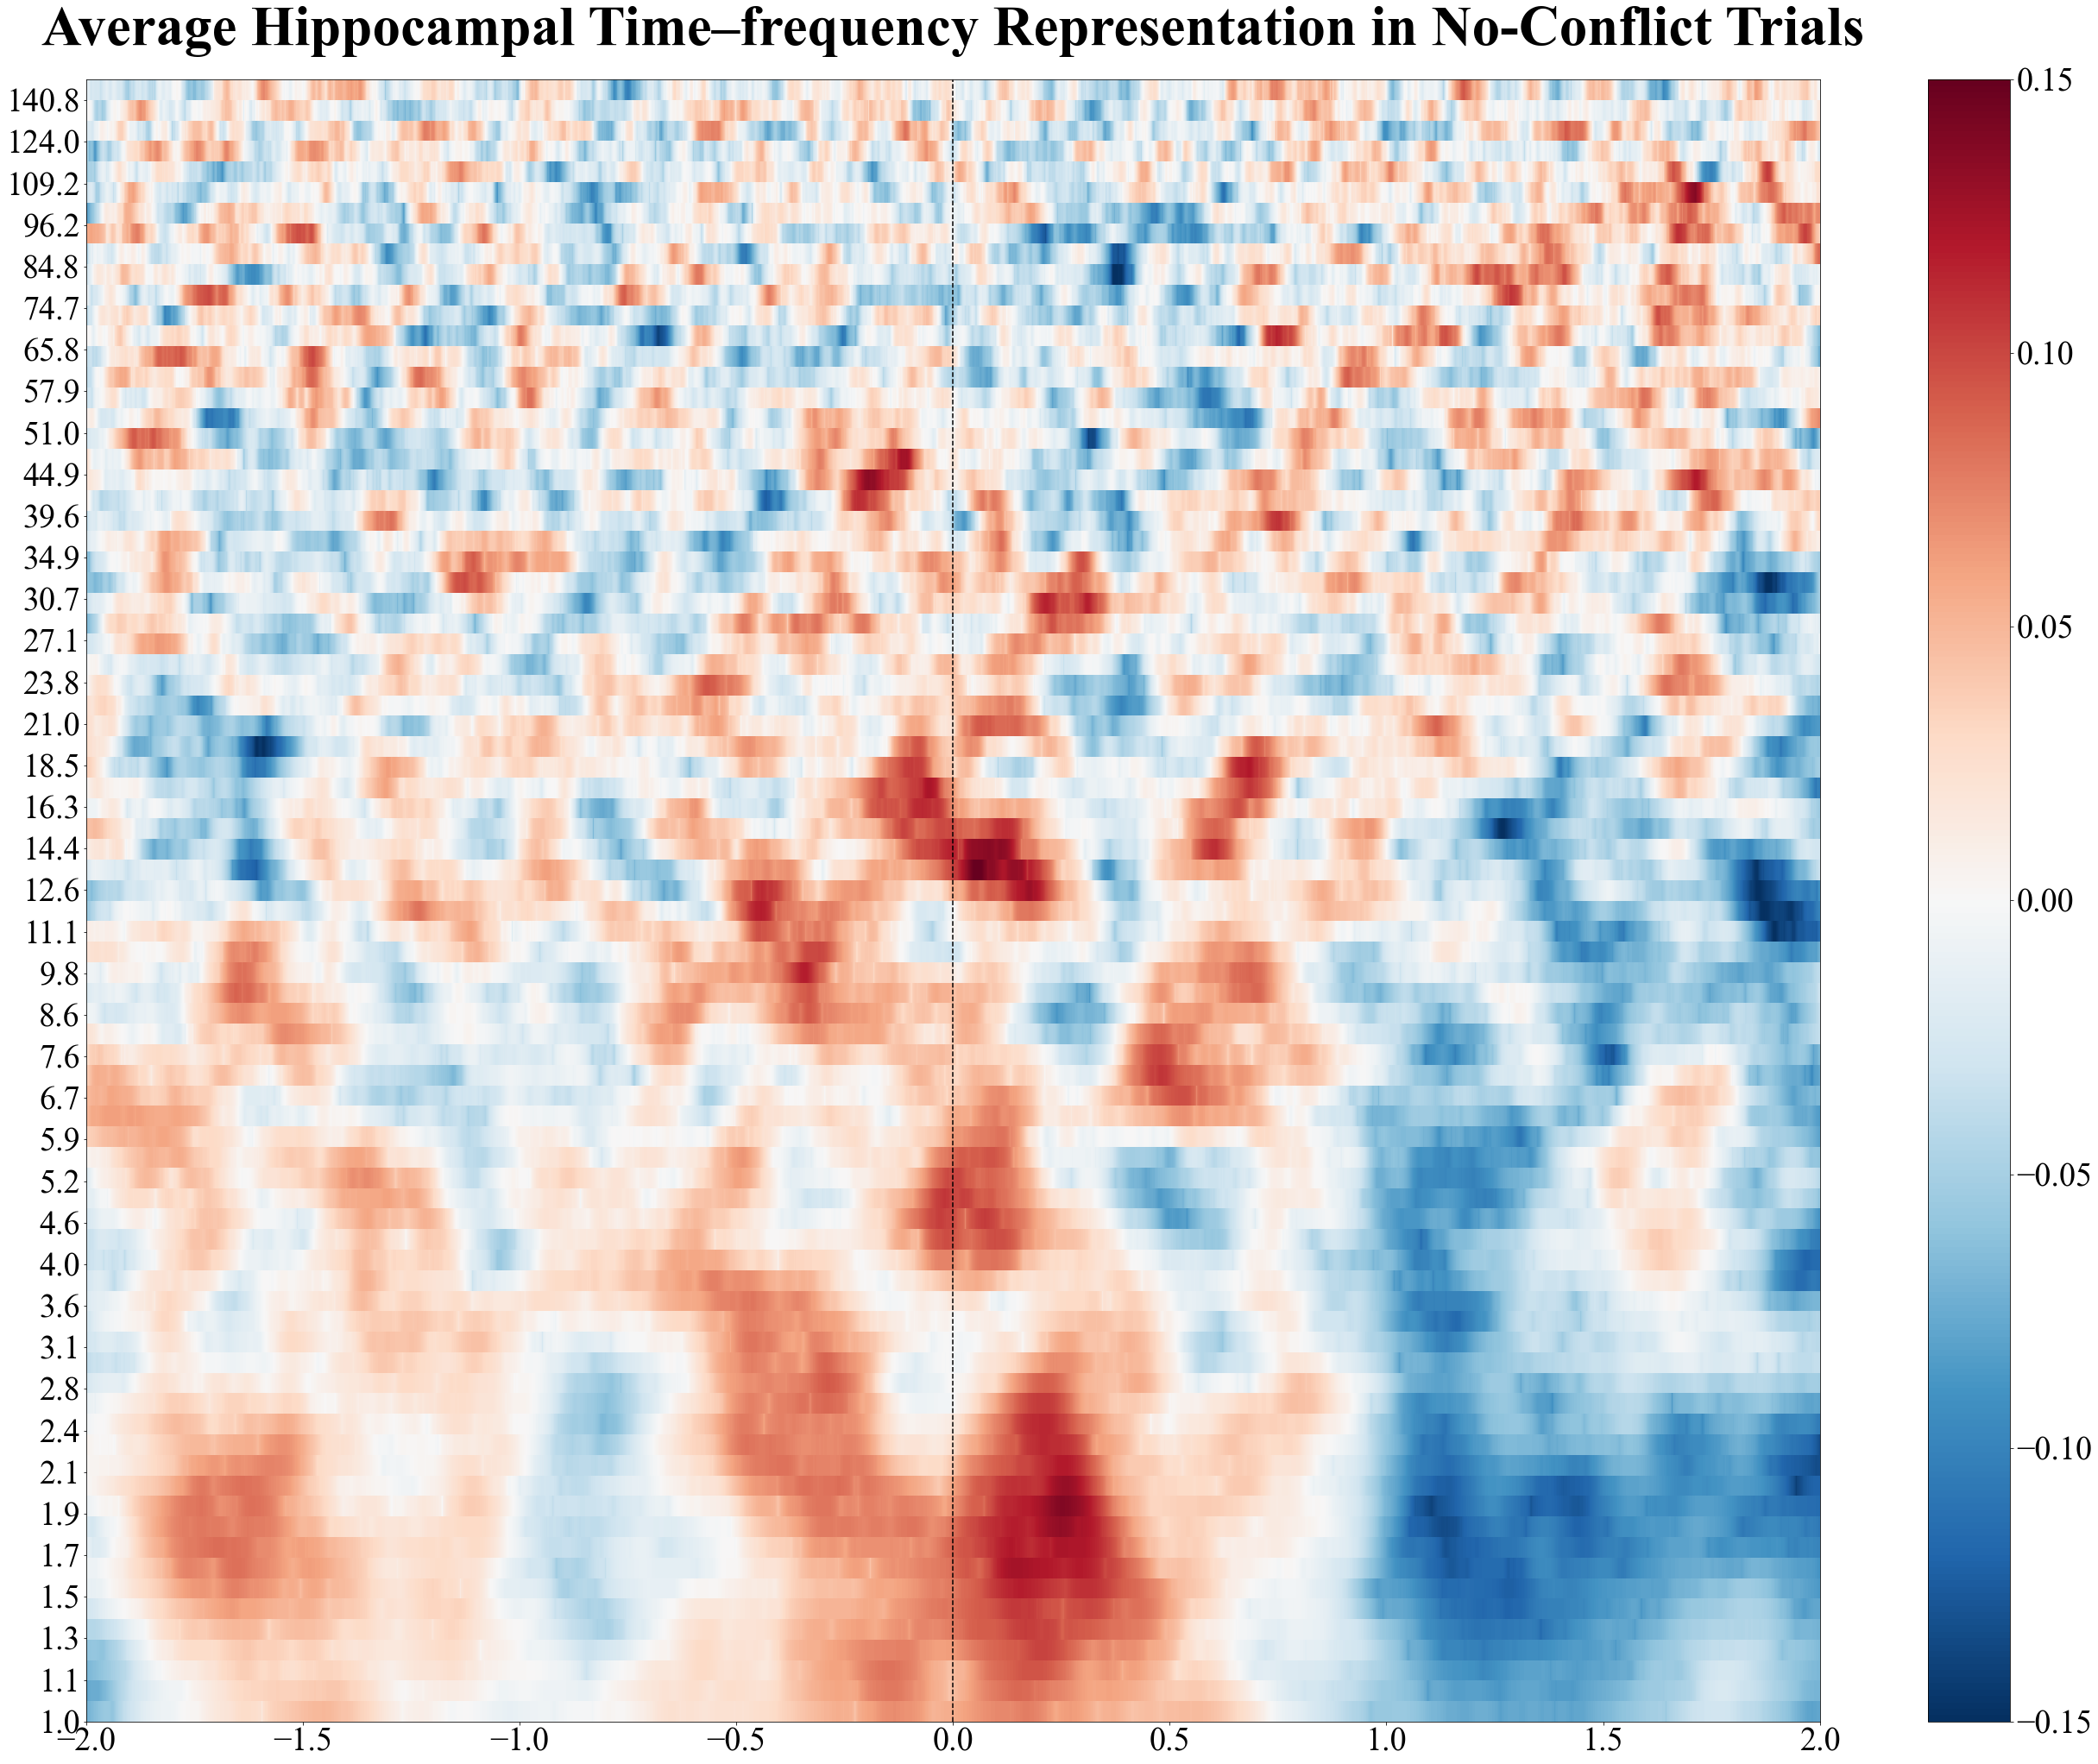

In [73]:
plot_allsub_averages(all_subs_noghost_average_hc, "Average Hippocampal Time–frequency Representation in No-Conflict Trials", 'average_hc_noconflict_all_subs.png')

## OFC

In [74]:
sub_list = ['SLCH002', 'BJH016', 'BJH021', 'BJH025', 'LL10', 'LL12', 'LL13']

all_subs_ghost_average_ofc, all_subs_noghost_average_ofc = calculate_last_away_average(sub_list, 'ofc')
    

Reading /home/brooke/pacman/preprocessing/SLCH002/ieeg/last_away/ofc_ghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/SLCH002/ieeg/last_away/ofc_noghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/BJH016/ieeg/last_away/ofc_ghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/BJH016/ieeg/last_away/ofc_noghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/BJH021/ieeg/last_away/ofc_ghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/BJH021/ieeg/last_away/ofc_noghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/BJH025/ieeg/last_away/ofc_ghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/BJH025/ieeg/last_away/ofc_noghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/LL10/ieeg/last_away/

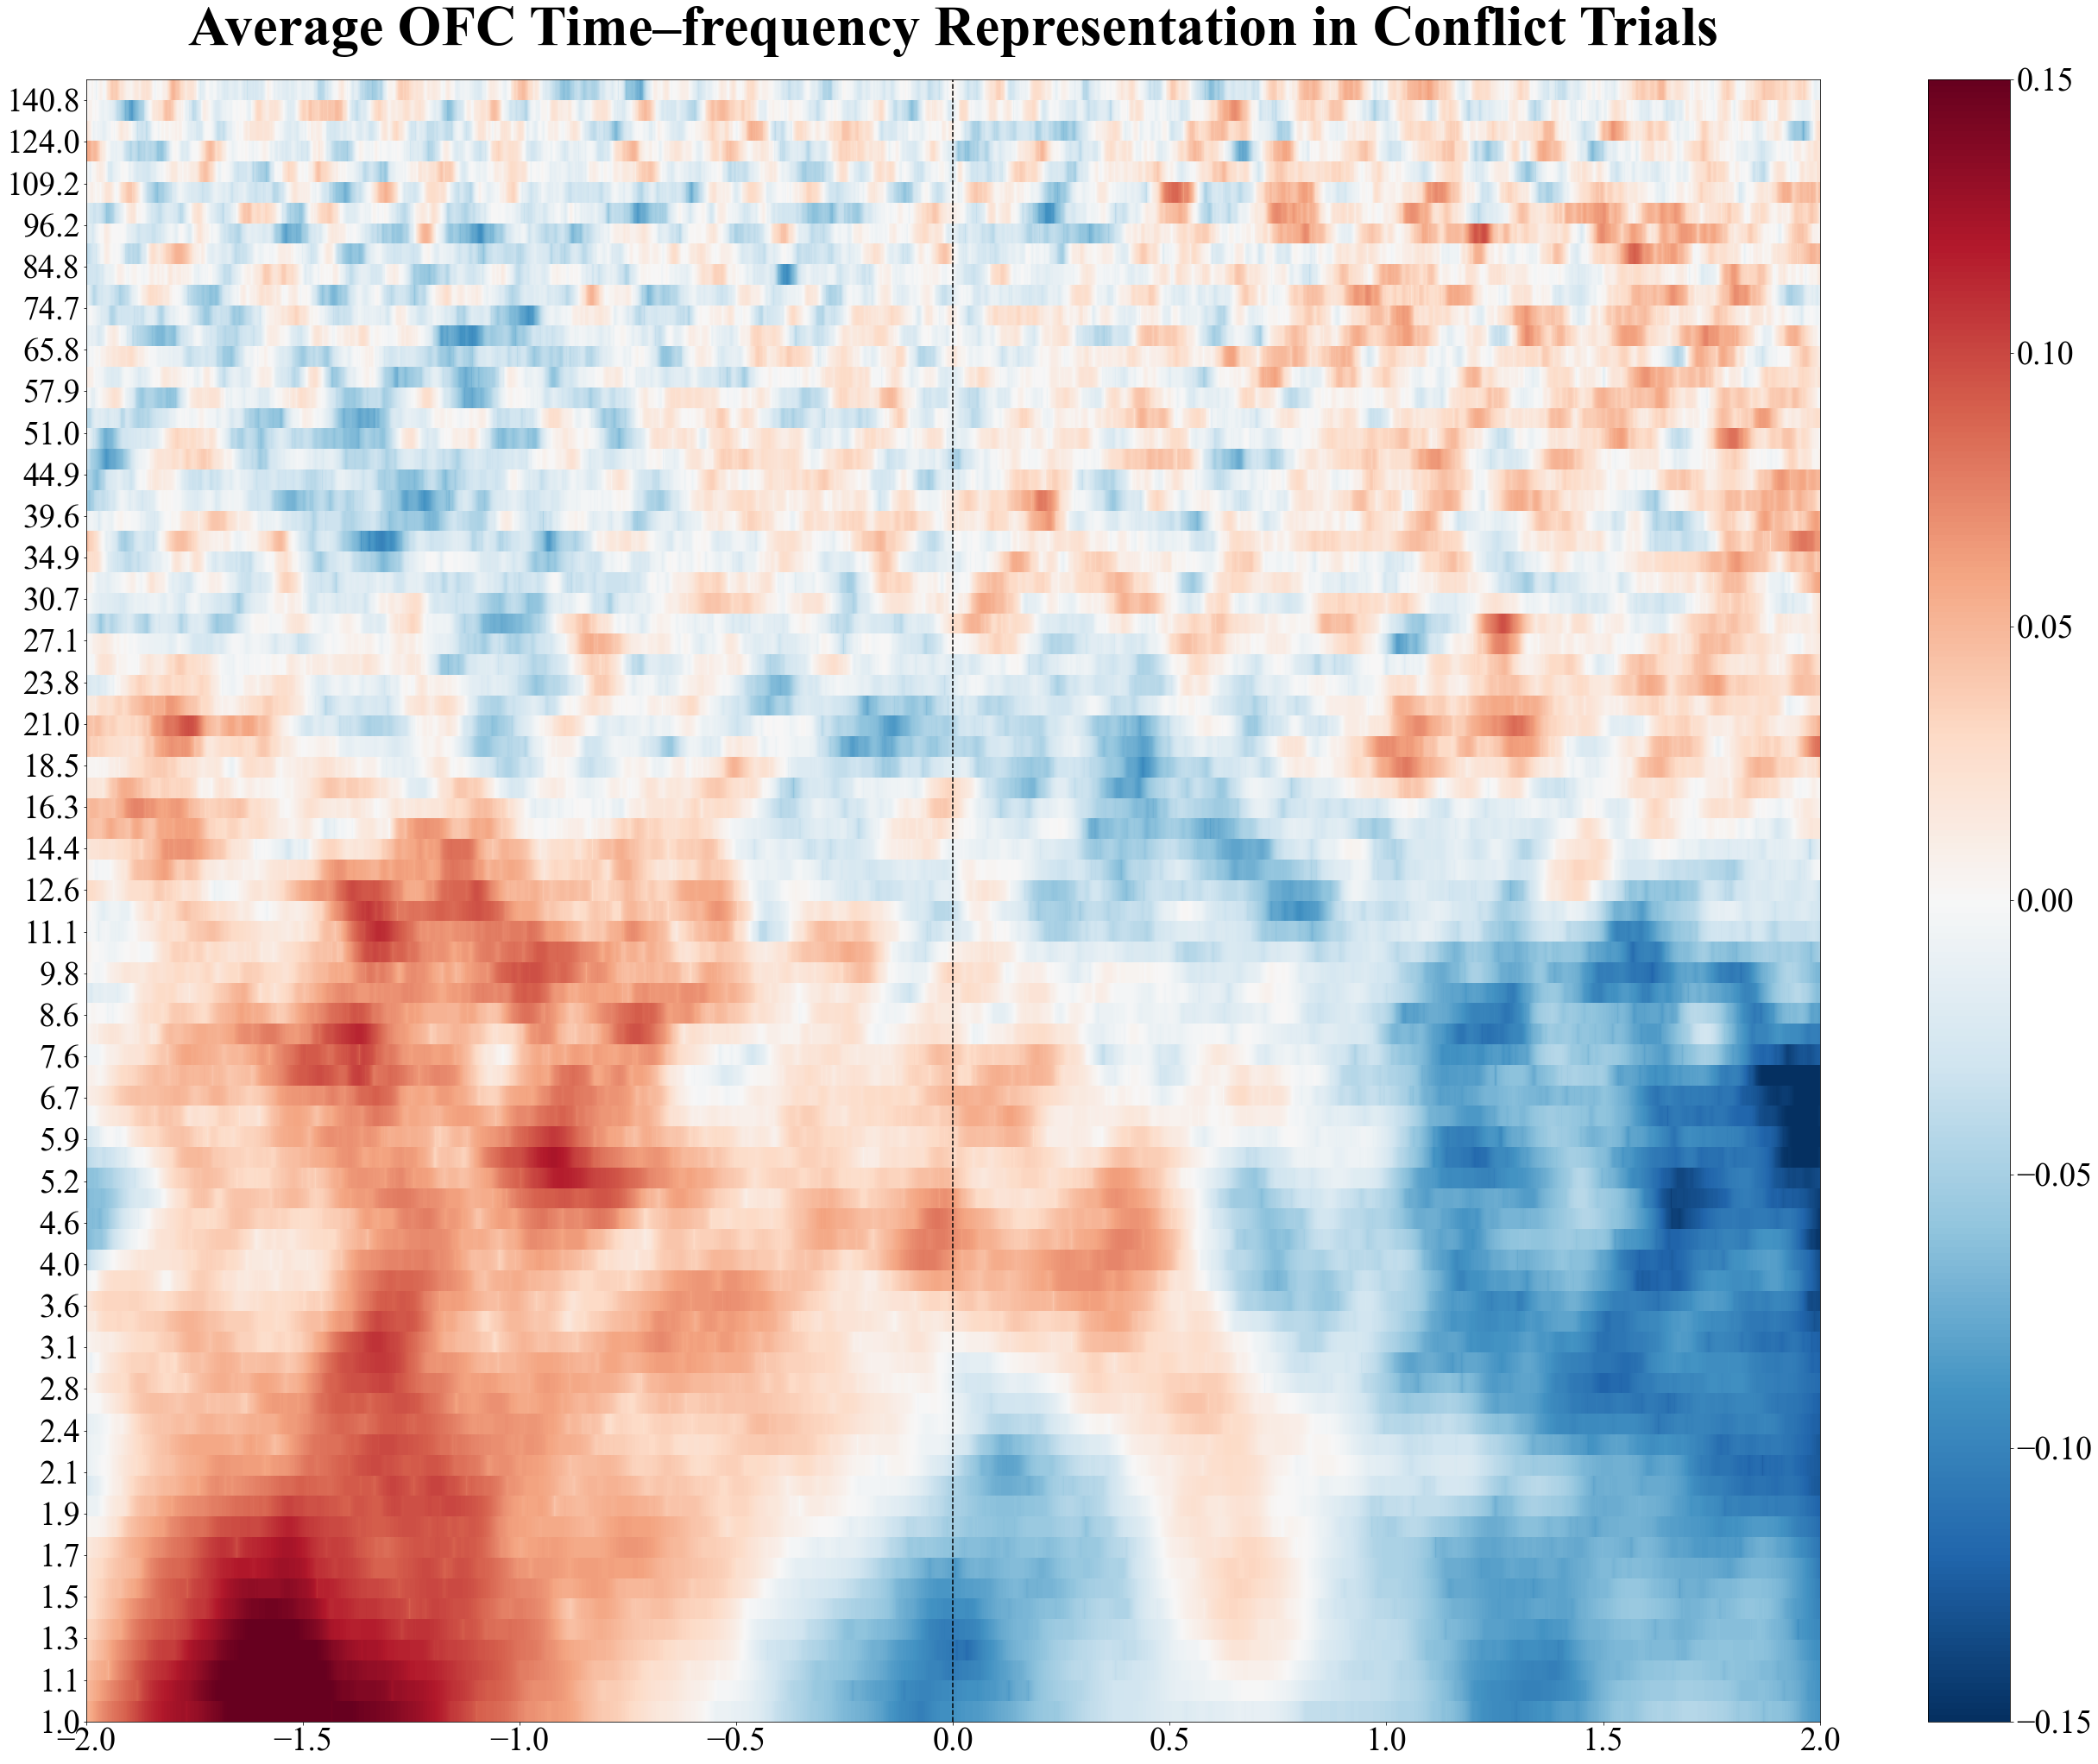

In [77]:
plot_allsub_averages(all_subs_ghost_average_ofc, "Average OFC Time–frequency Representation in Conflict Trials", 'average_ofc_conflict_all_subs.png')

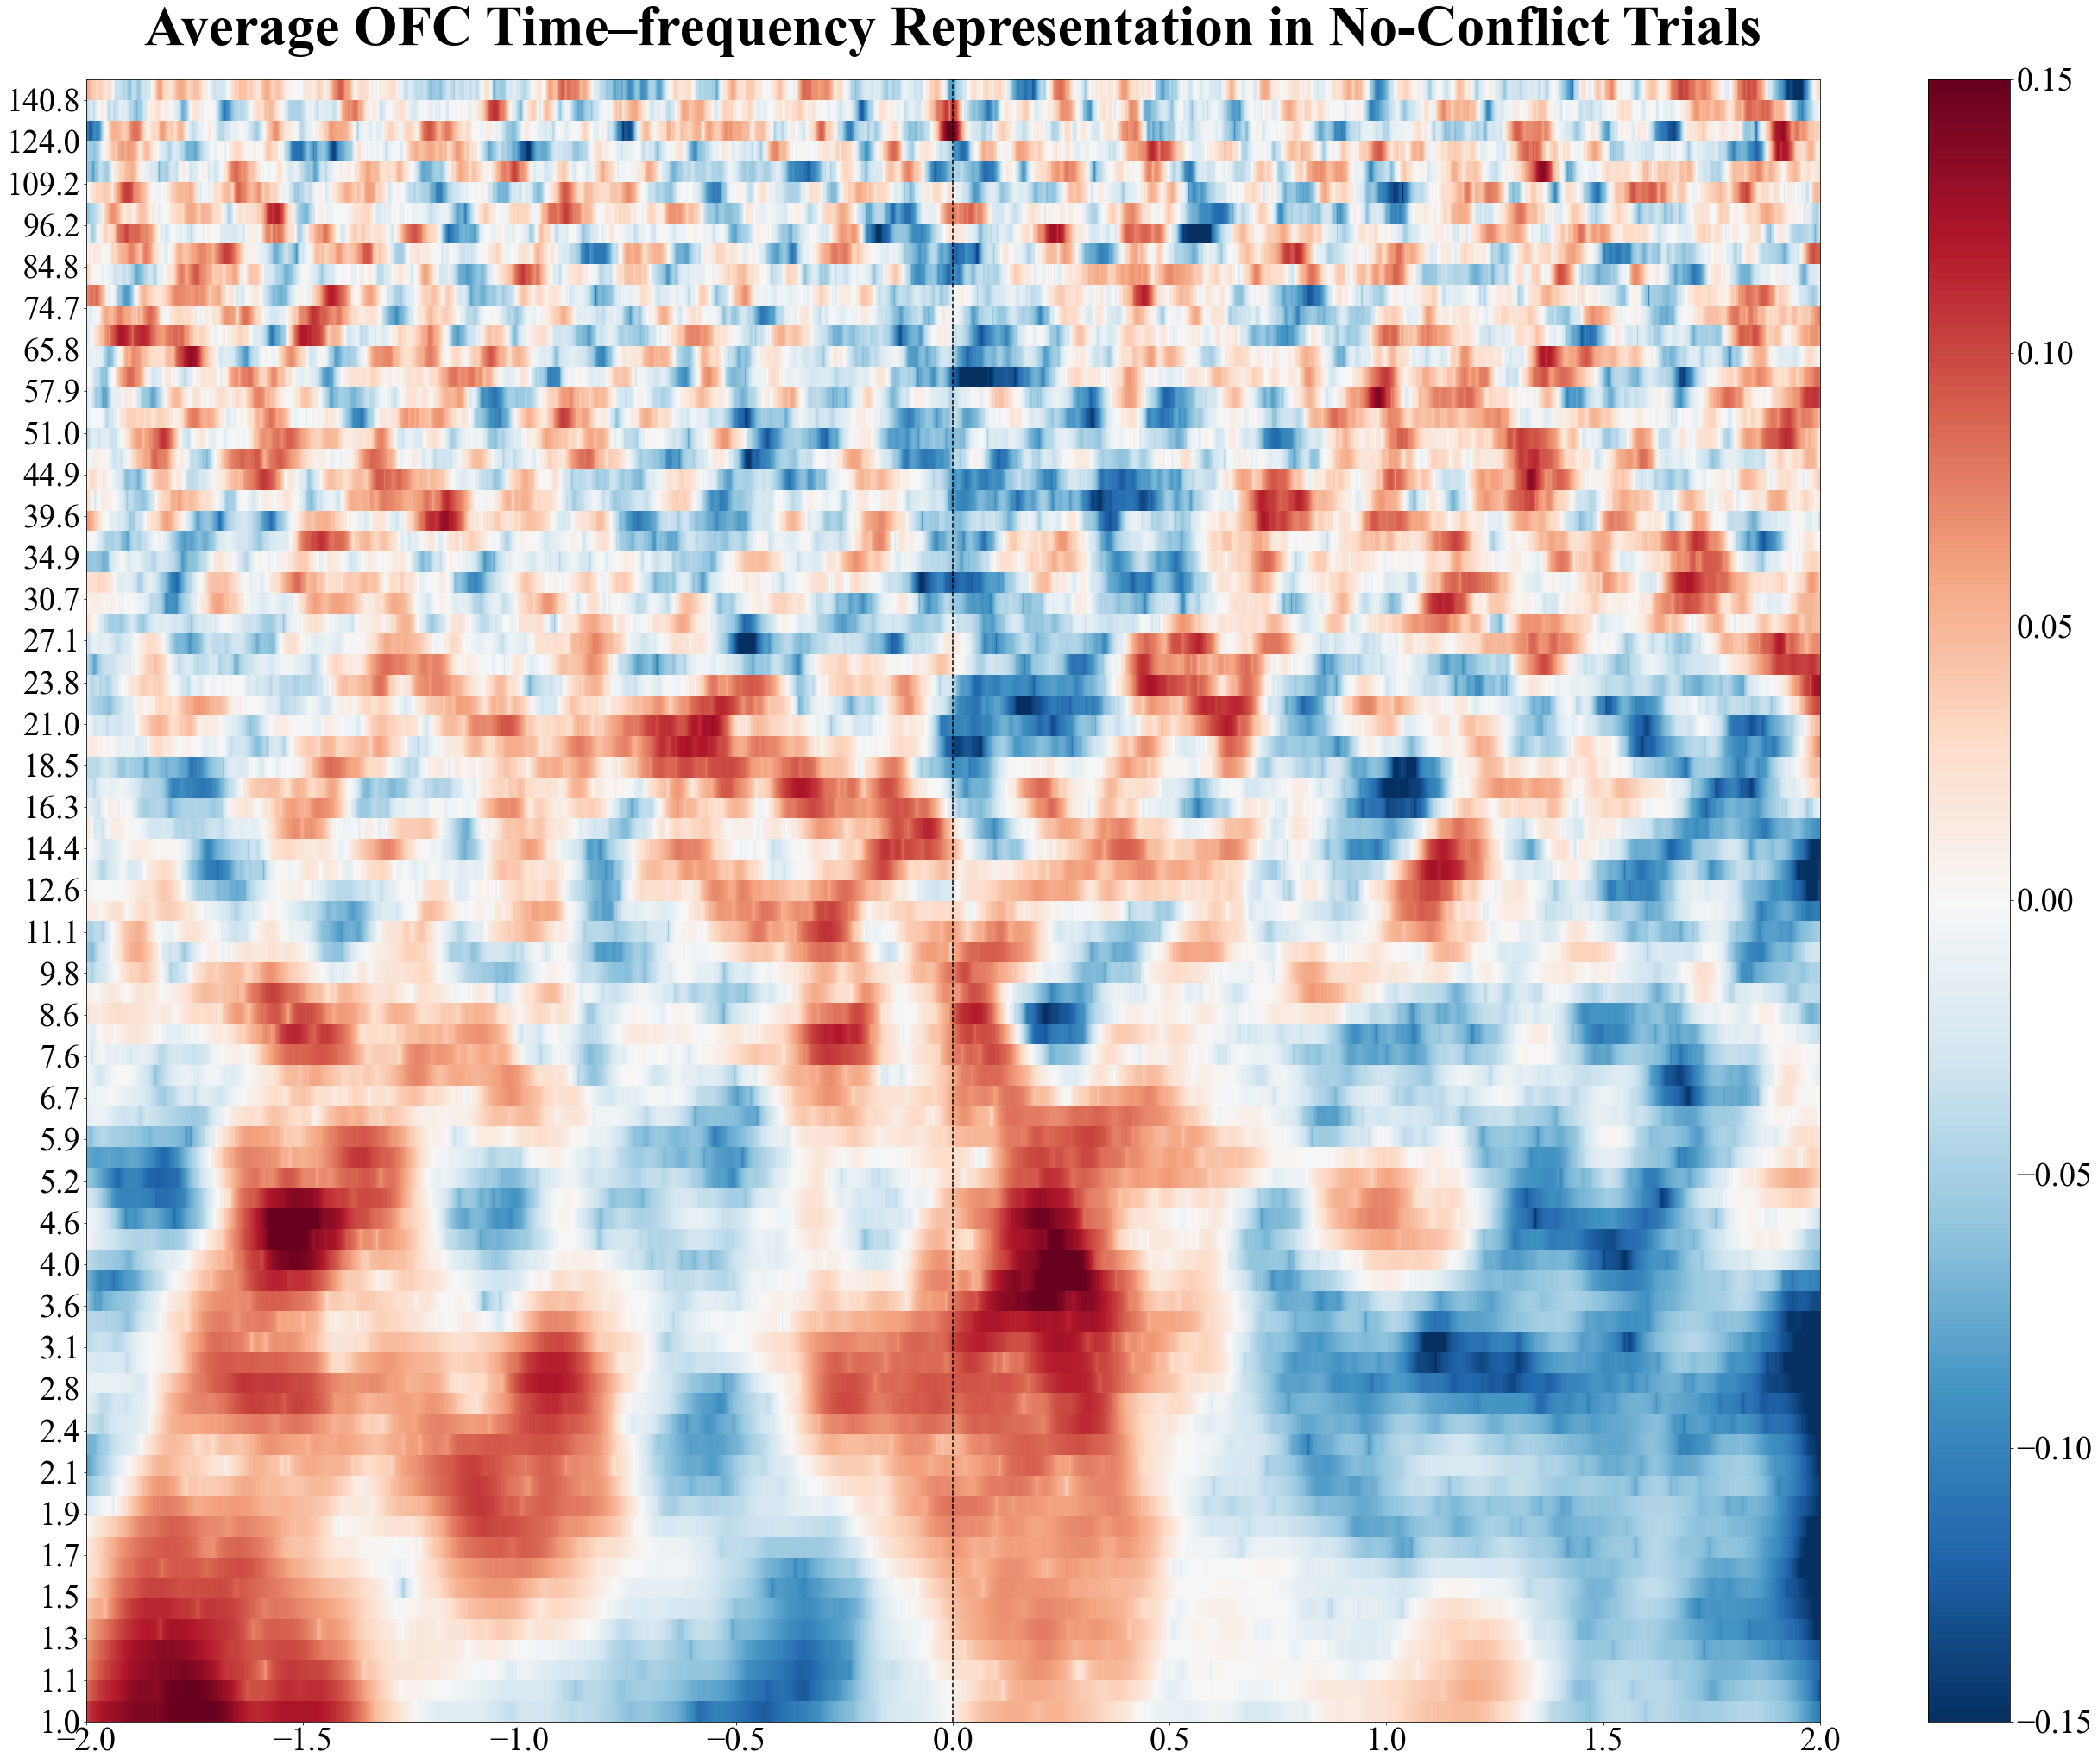

In [78]:
plot_allsub_averages(all_subs_noghost_average_ofc, "Average OFC Time–frequency Representation in No-Conflict Trials", 'average_ofc_noconflict_all_subs.png')

## Anterior Cingulate

In [79]:
sub_list = ['SLCH002', 'BJH016', 'BJH021', 'BJH025', 'LL10', 'LL12', 'LL13']

all_subs_ghost_average_cing, all_subs_noghost_average_cing = calculate_last_away_average(sub_list, 'cing')
    

Reading /home/brooke/pacman/preprocessing/SLCH002/ieeg/last_away/cing_ghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/SLCH002/ieeg/last_away/cing_noghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/BJH016/ieeg/last_away/cing_ghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/BJH016/ieeg/last_away/cing_noghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/BJH021/ieeg/last_away/cing_ghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/BJH021/ieeg/last_away/cing_noghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/BJH025/ieeg/last_away/cing_ghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/BJH025/ieeg/last_away/cing_noghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/LL10/ieeg/la

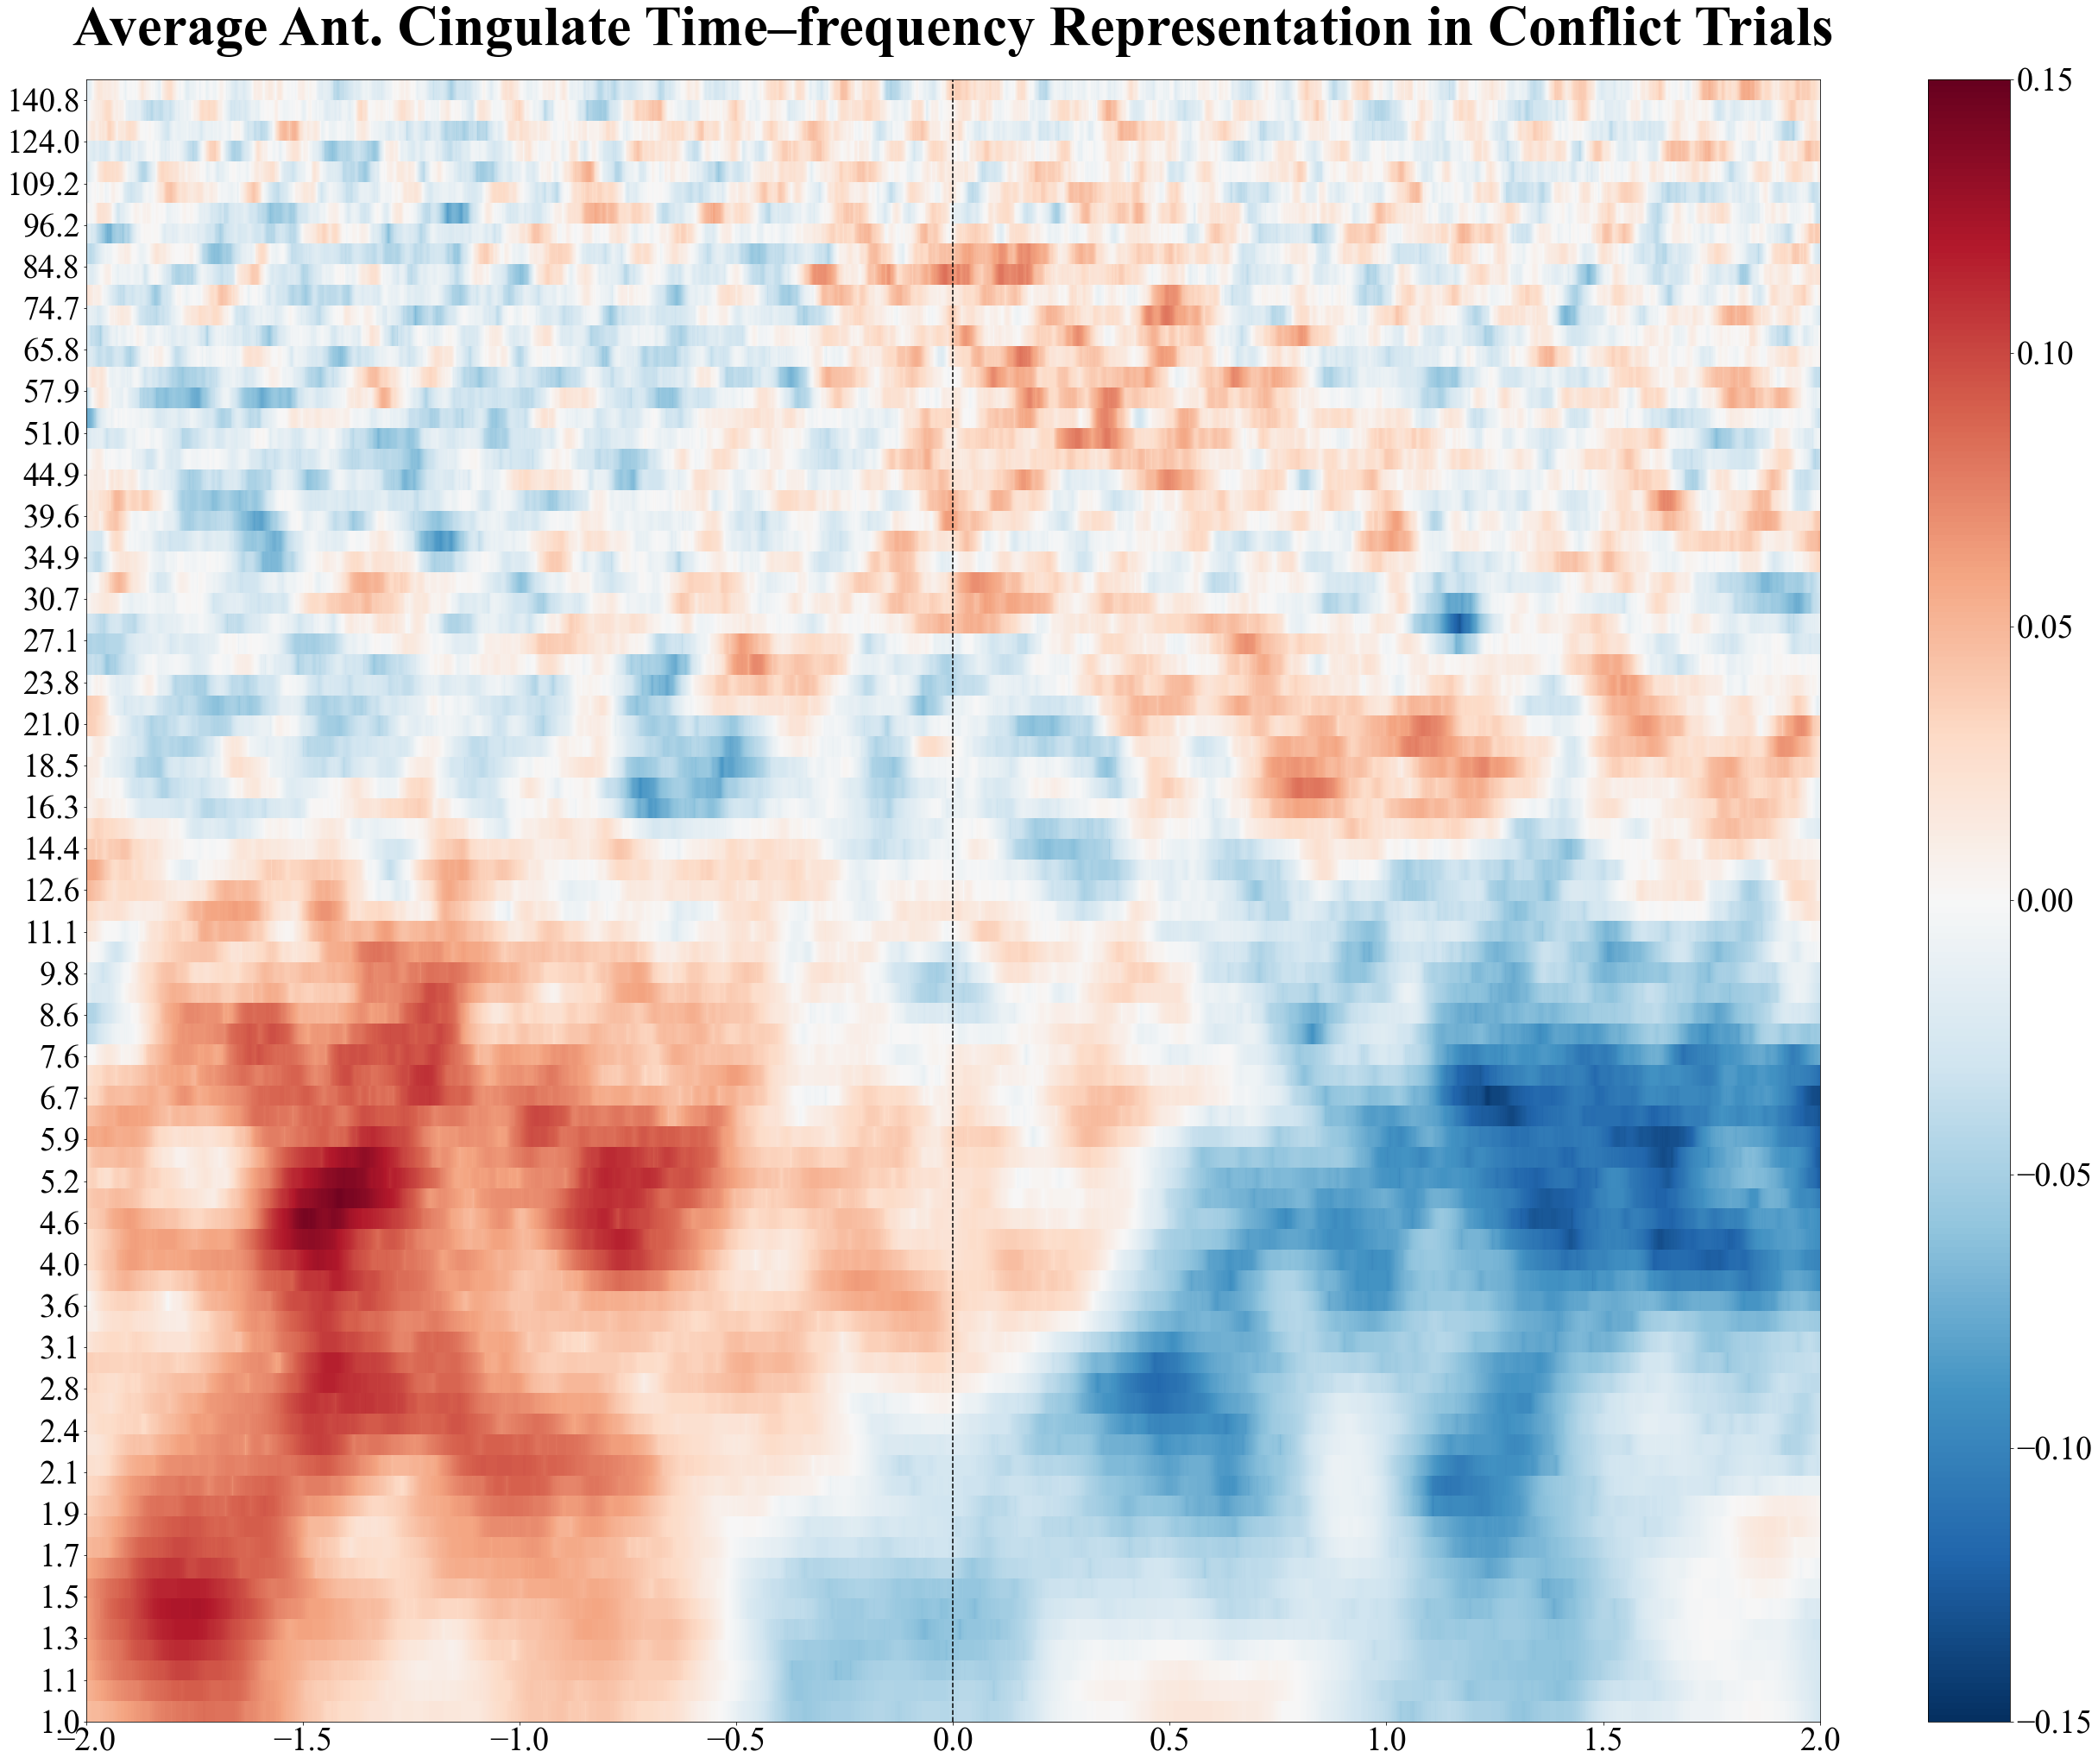

In [80]:
plot_allsub_averages(all_subs_ghost_average_cing, "Average Ant. Cingulate Time–frequency Representation in Conflict Trials", 'average_cing_conflict_all_subs.png')

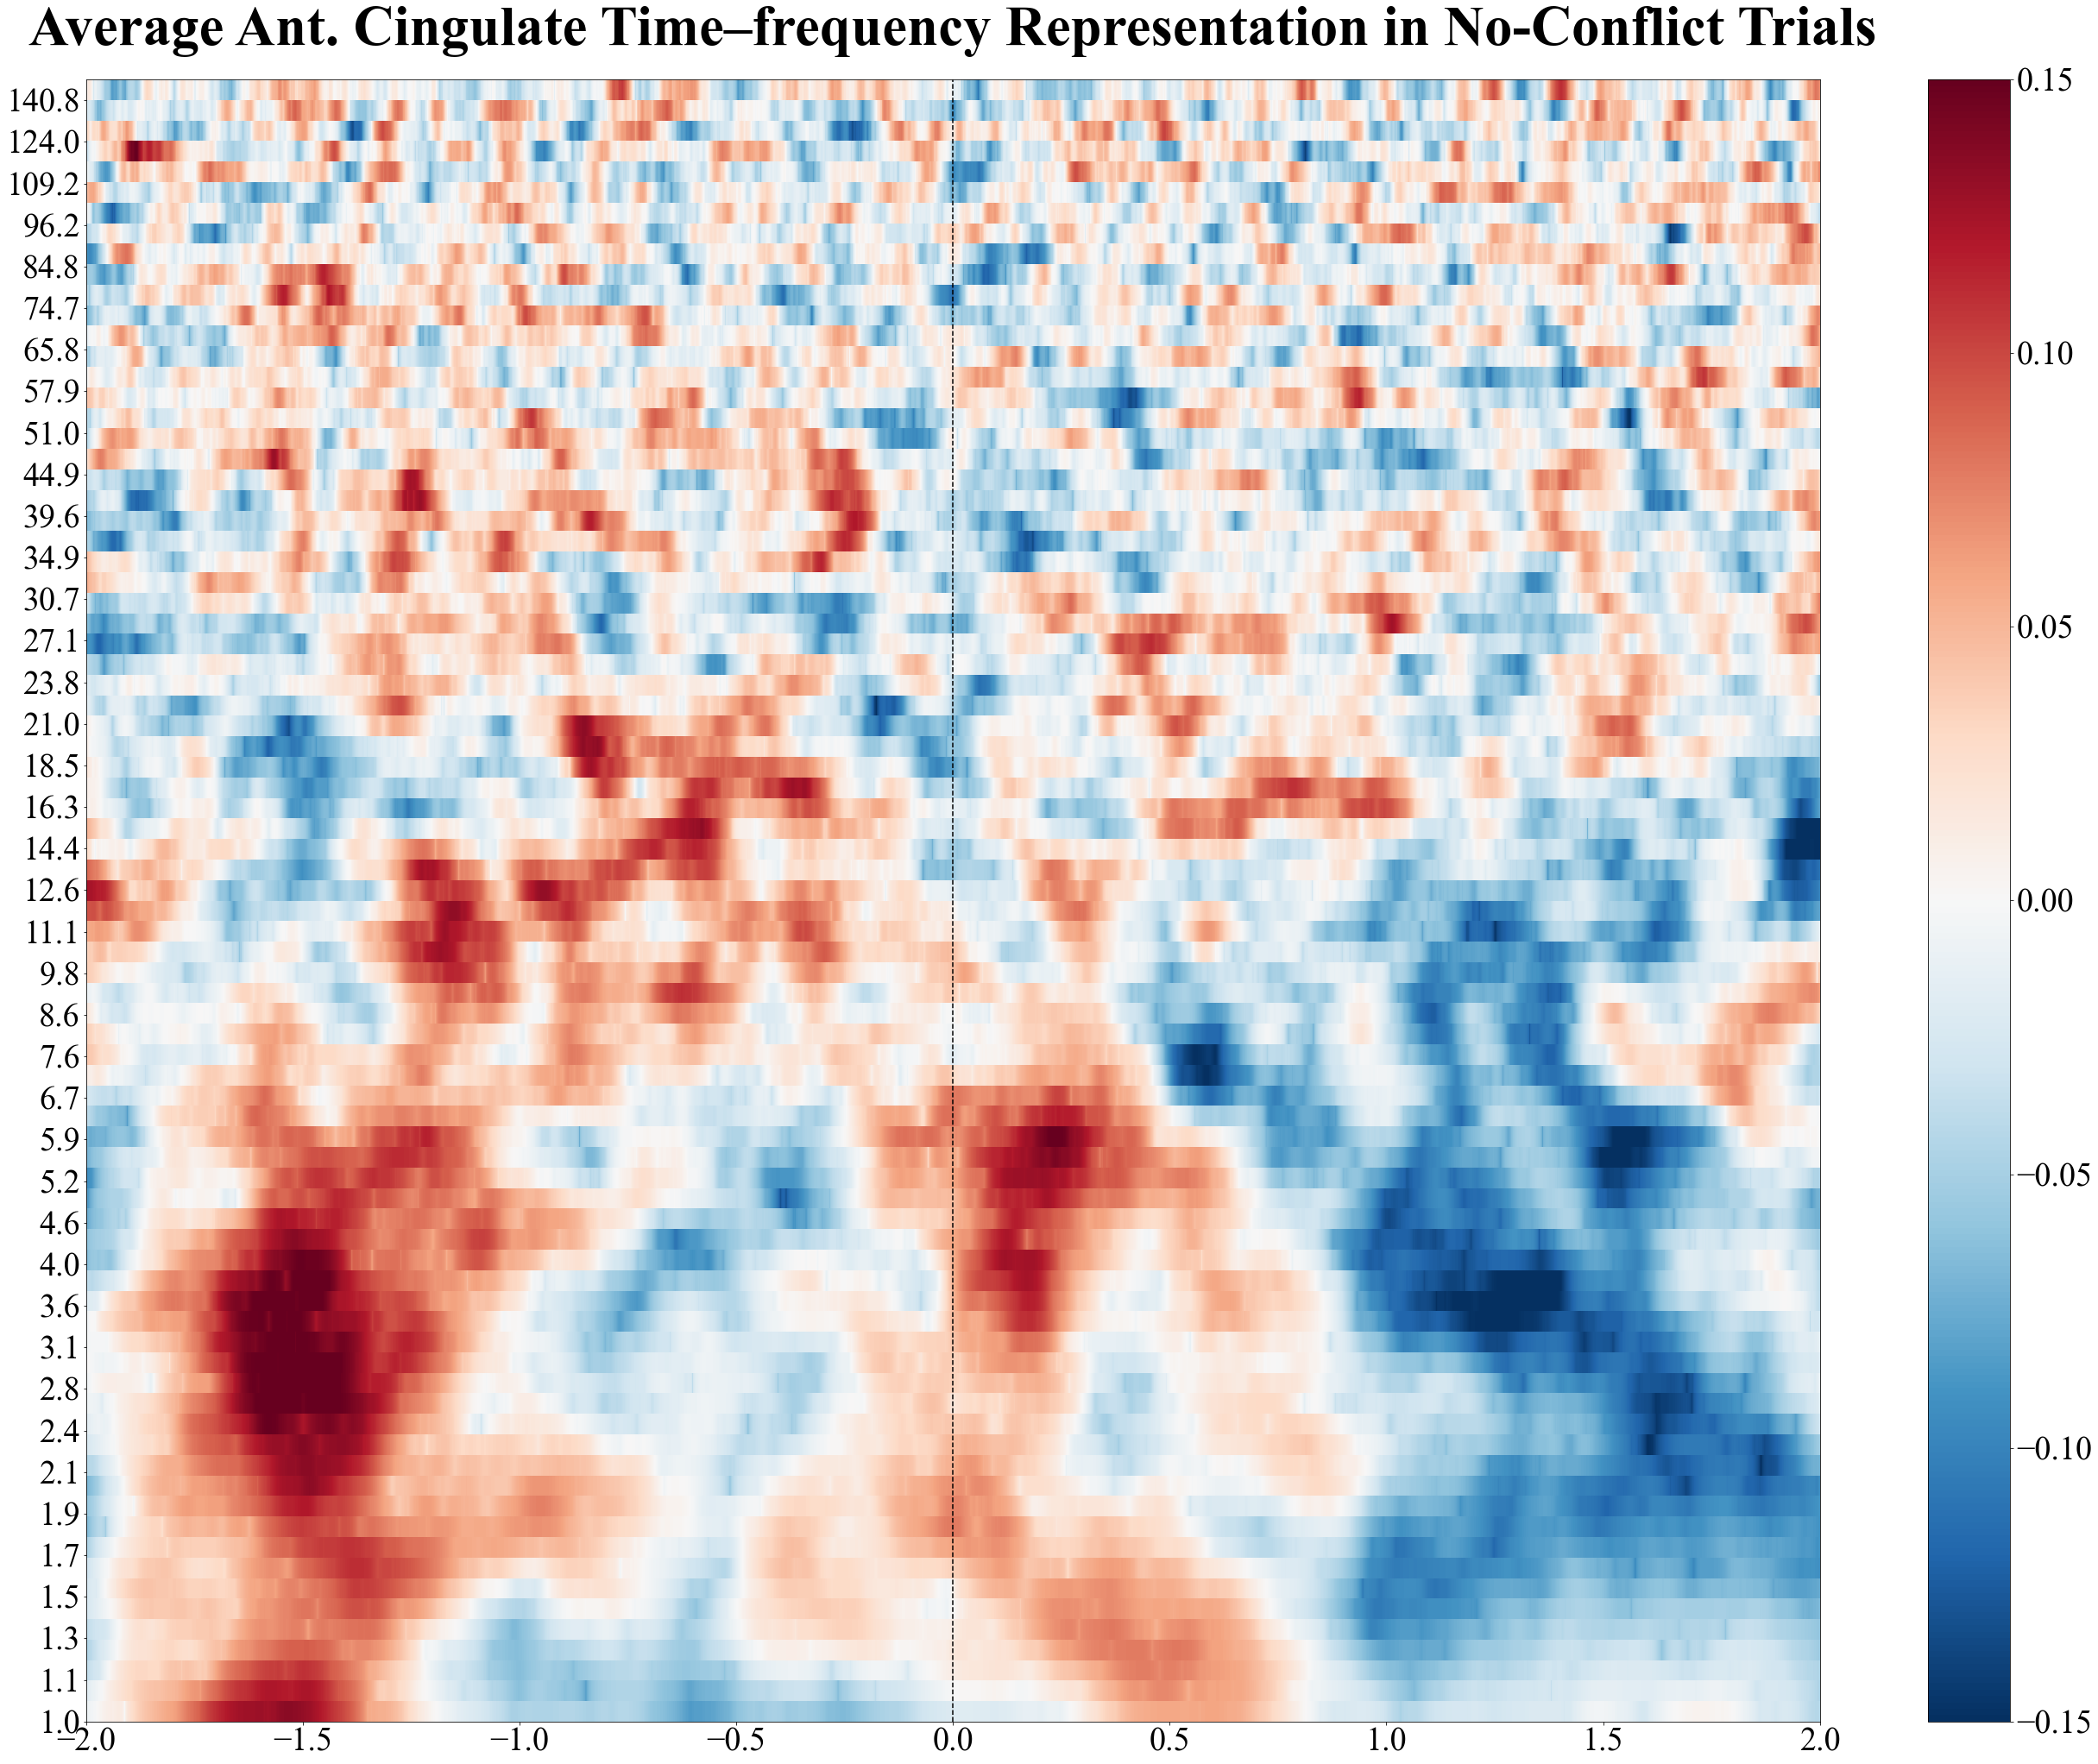

In [81]:
plot_allsub_averages(all_subs_noghost_average_cing, "Average Ant. Cingulate Time–frequency Representation in No-Conflict Trials", 'average_cing_noconflict_all_subs.png')

## Amygdala

In [82]:
sub_list = ['SLCH002', 'BJH016', 'BJH021', 'BJH025', 'LL10', 'LL12', 'LL13']

all_subs_ghost_average_amyg, all_subs_noghost_average_amyg = calculate_last_away_average(sub_list, 'amyg')
    

Reading /home/brooke/pacman/preprocessing/SLCH002/ieeg/last_away/amyg_ghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/SLCH002/ieeg/last_away/amyg_noghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/BJH016/ieeg/last_away/amyg_ghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/BJH016/ieeg/last_away/amyg_noghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/BJH021/ieeg/last_away/amyg_ghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/BJH021/ieeg/last_away/amyg_noghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/BJH025/ieeg/last_away/amyg_ghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/BJH025/ieeg/last_away/amyg_noghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/LL10/ieeg/la

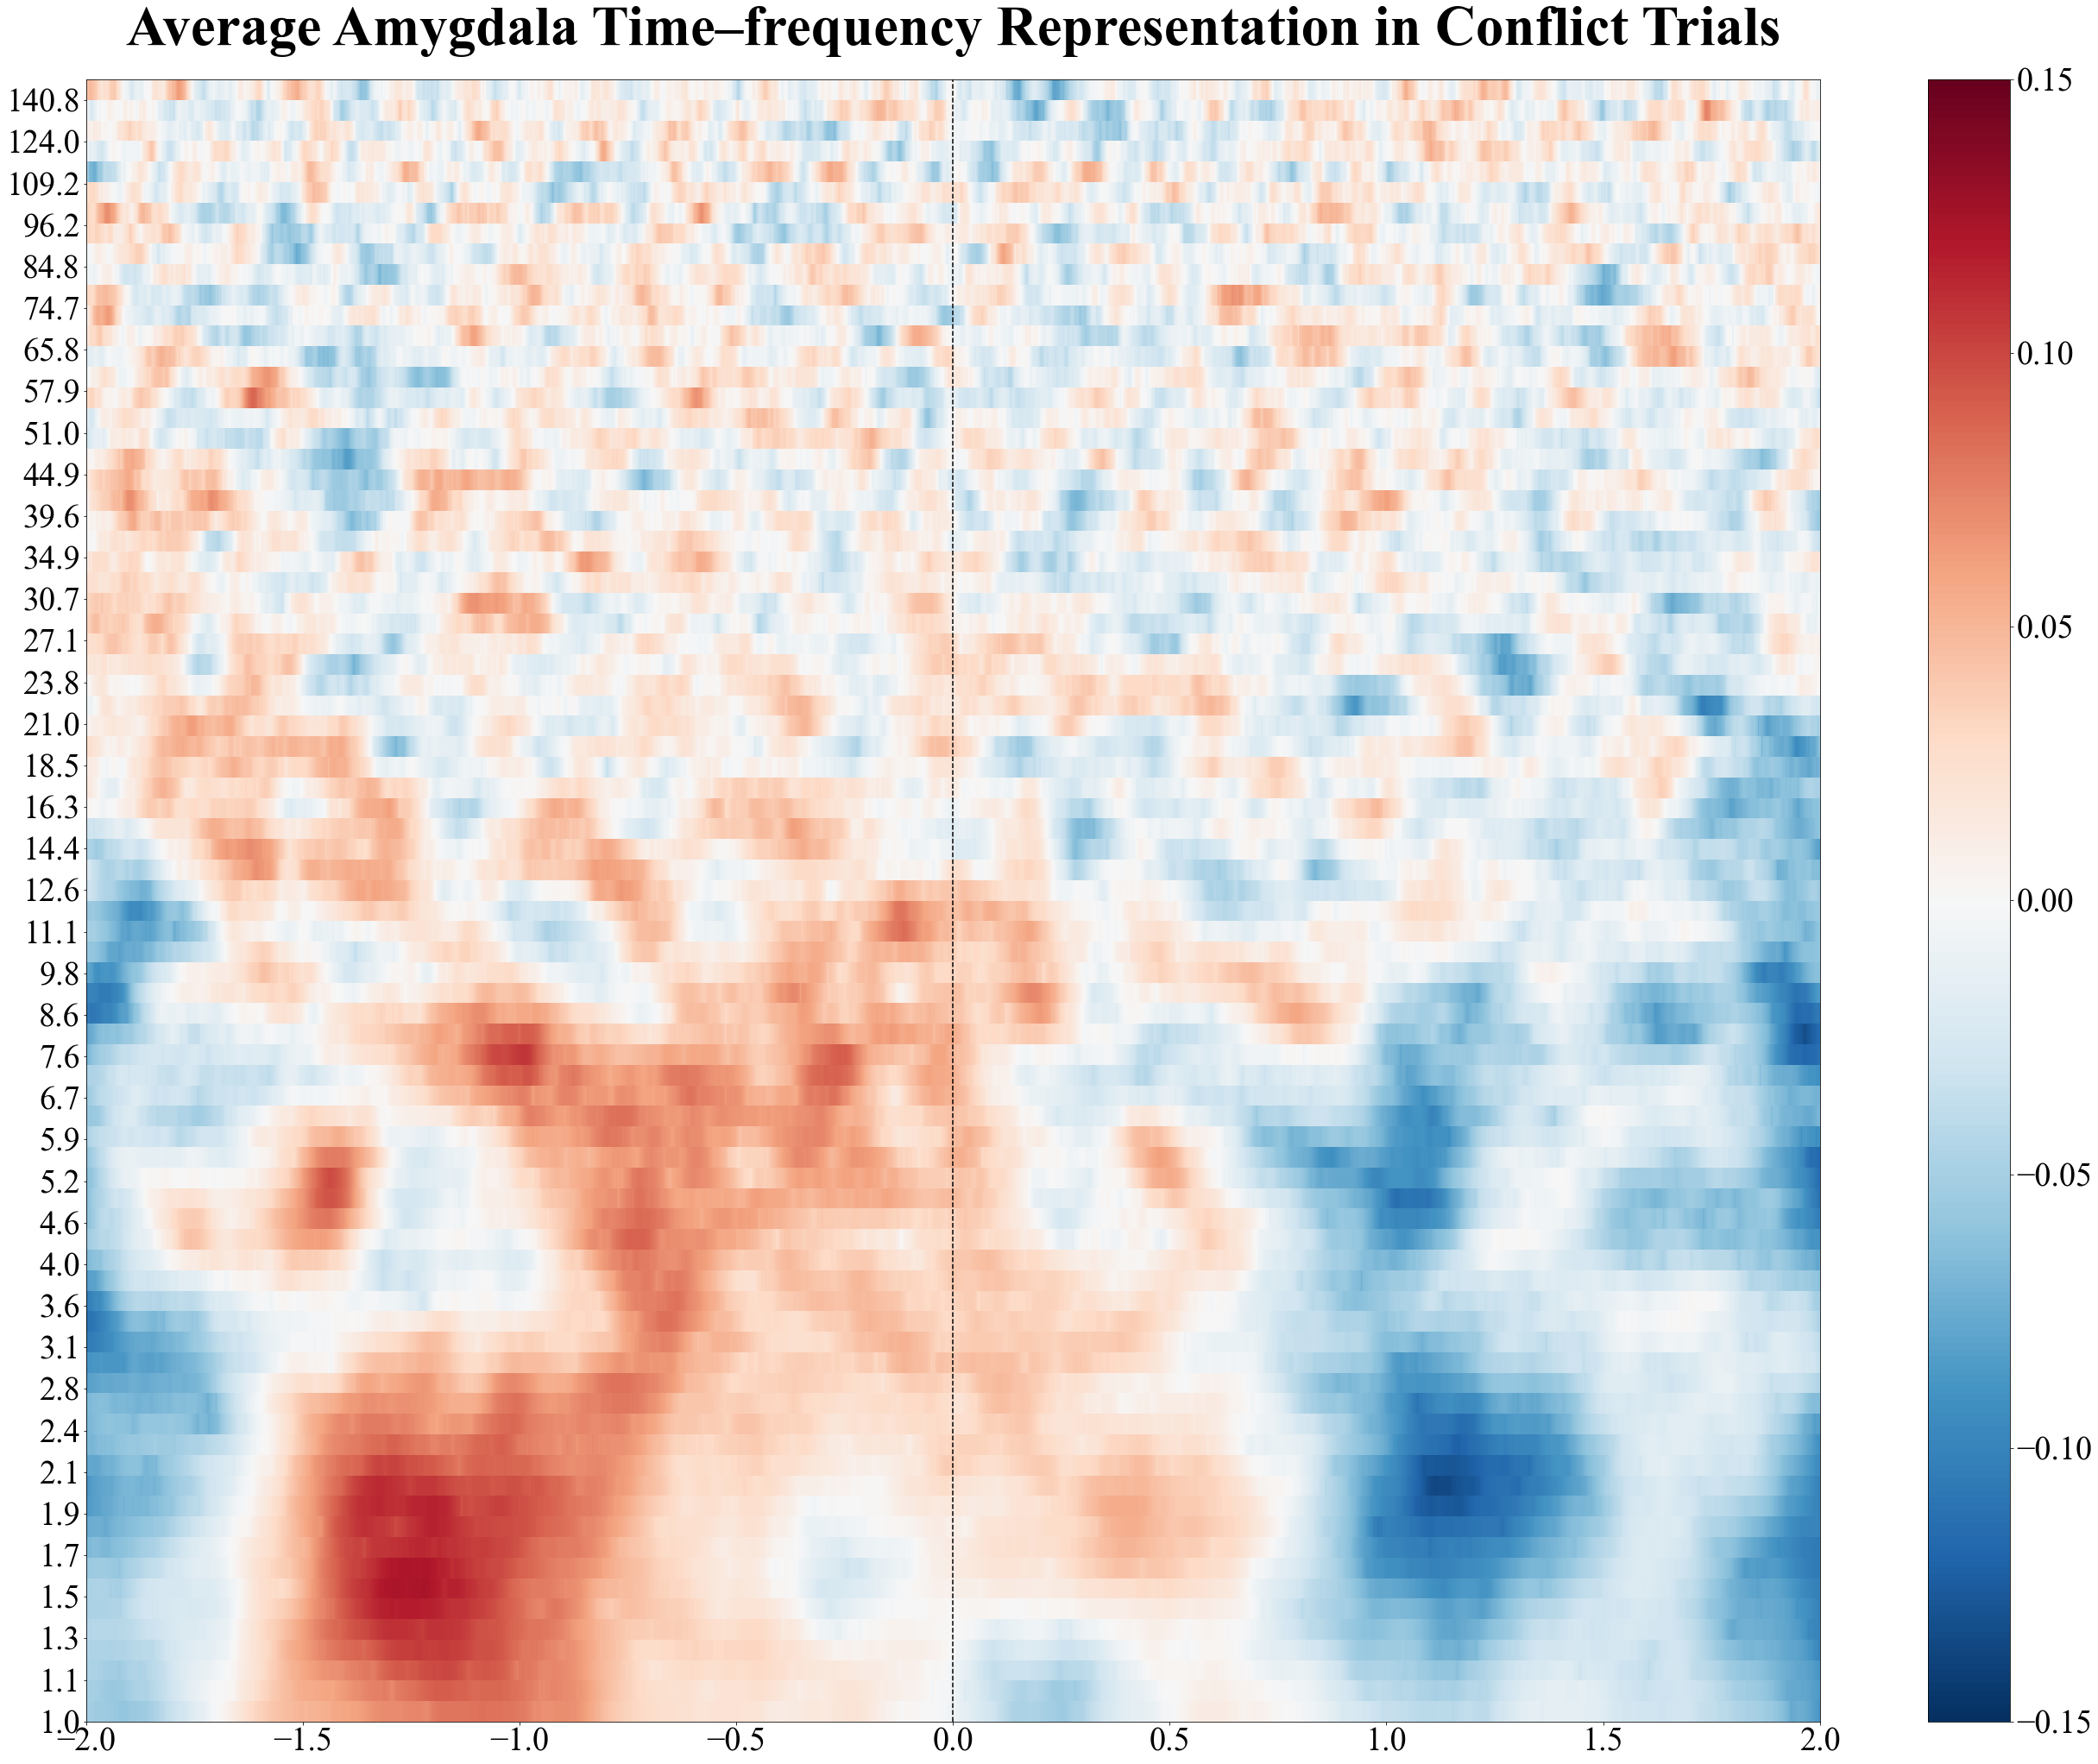

In [83]:
plot_allsub_averages(all_subs_ghost_average_amyg, "Average Amygdala Time–frequency Representation in Conflict Trials", 'average_amyg_conflict_all_subs.png')

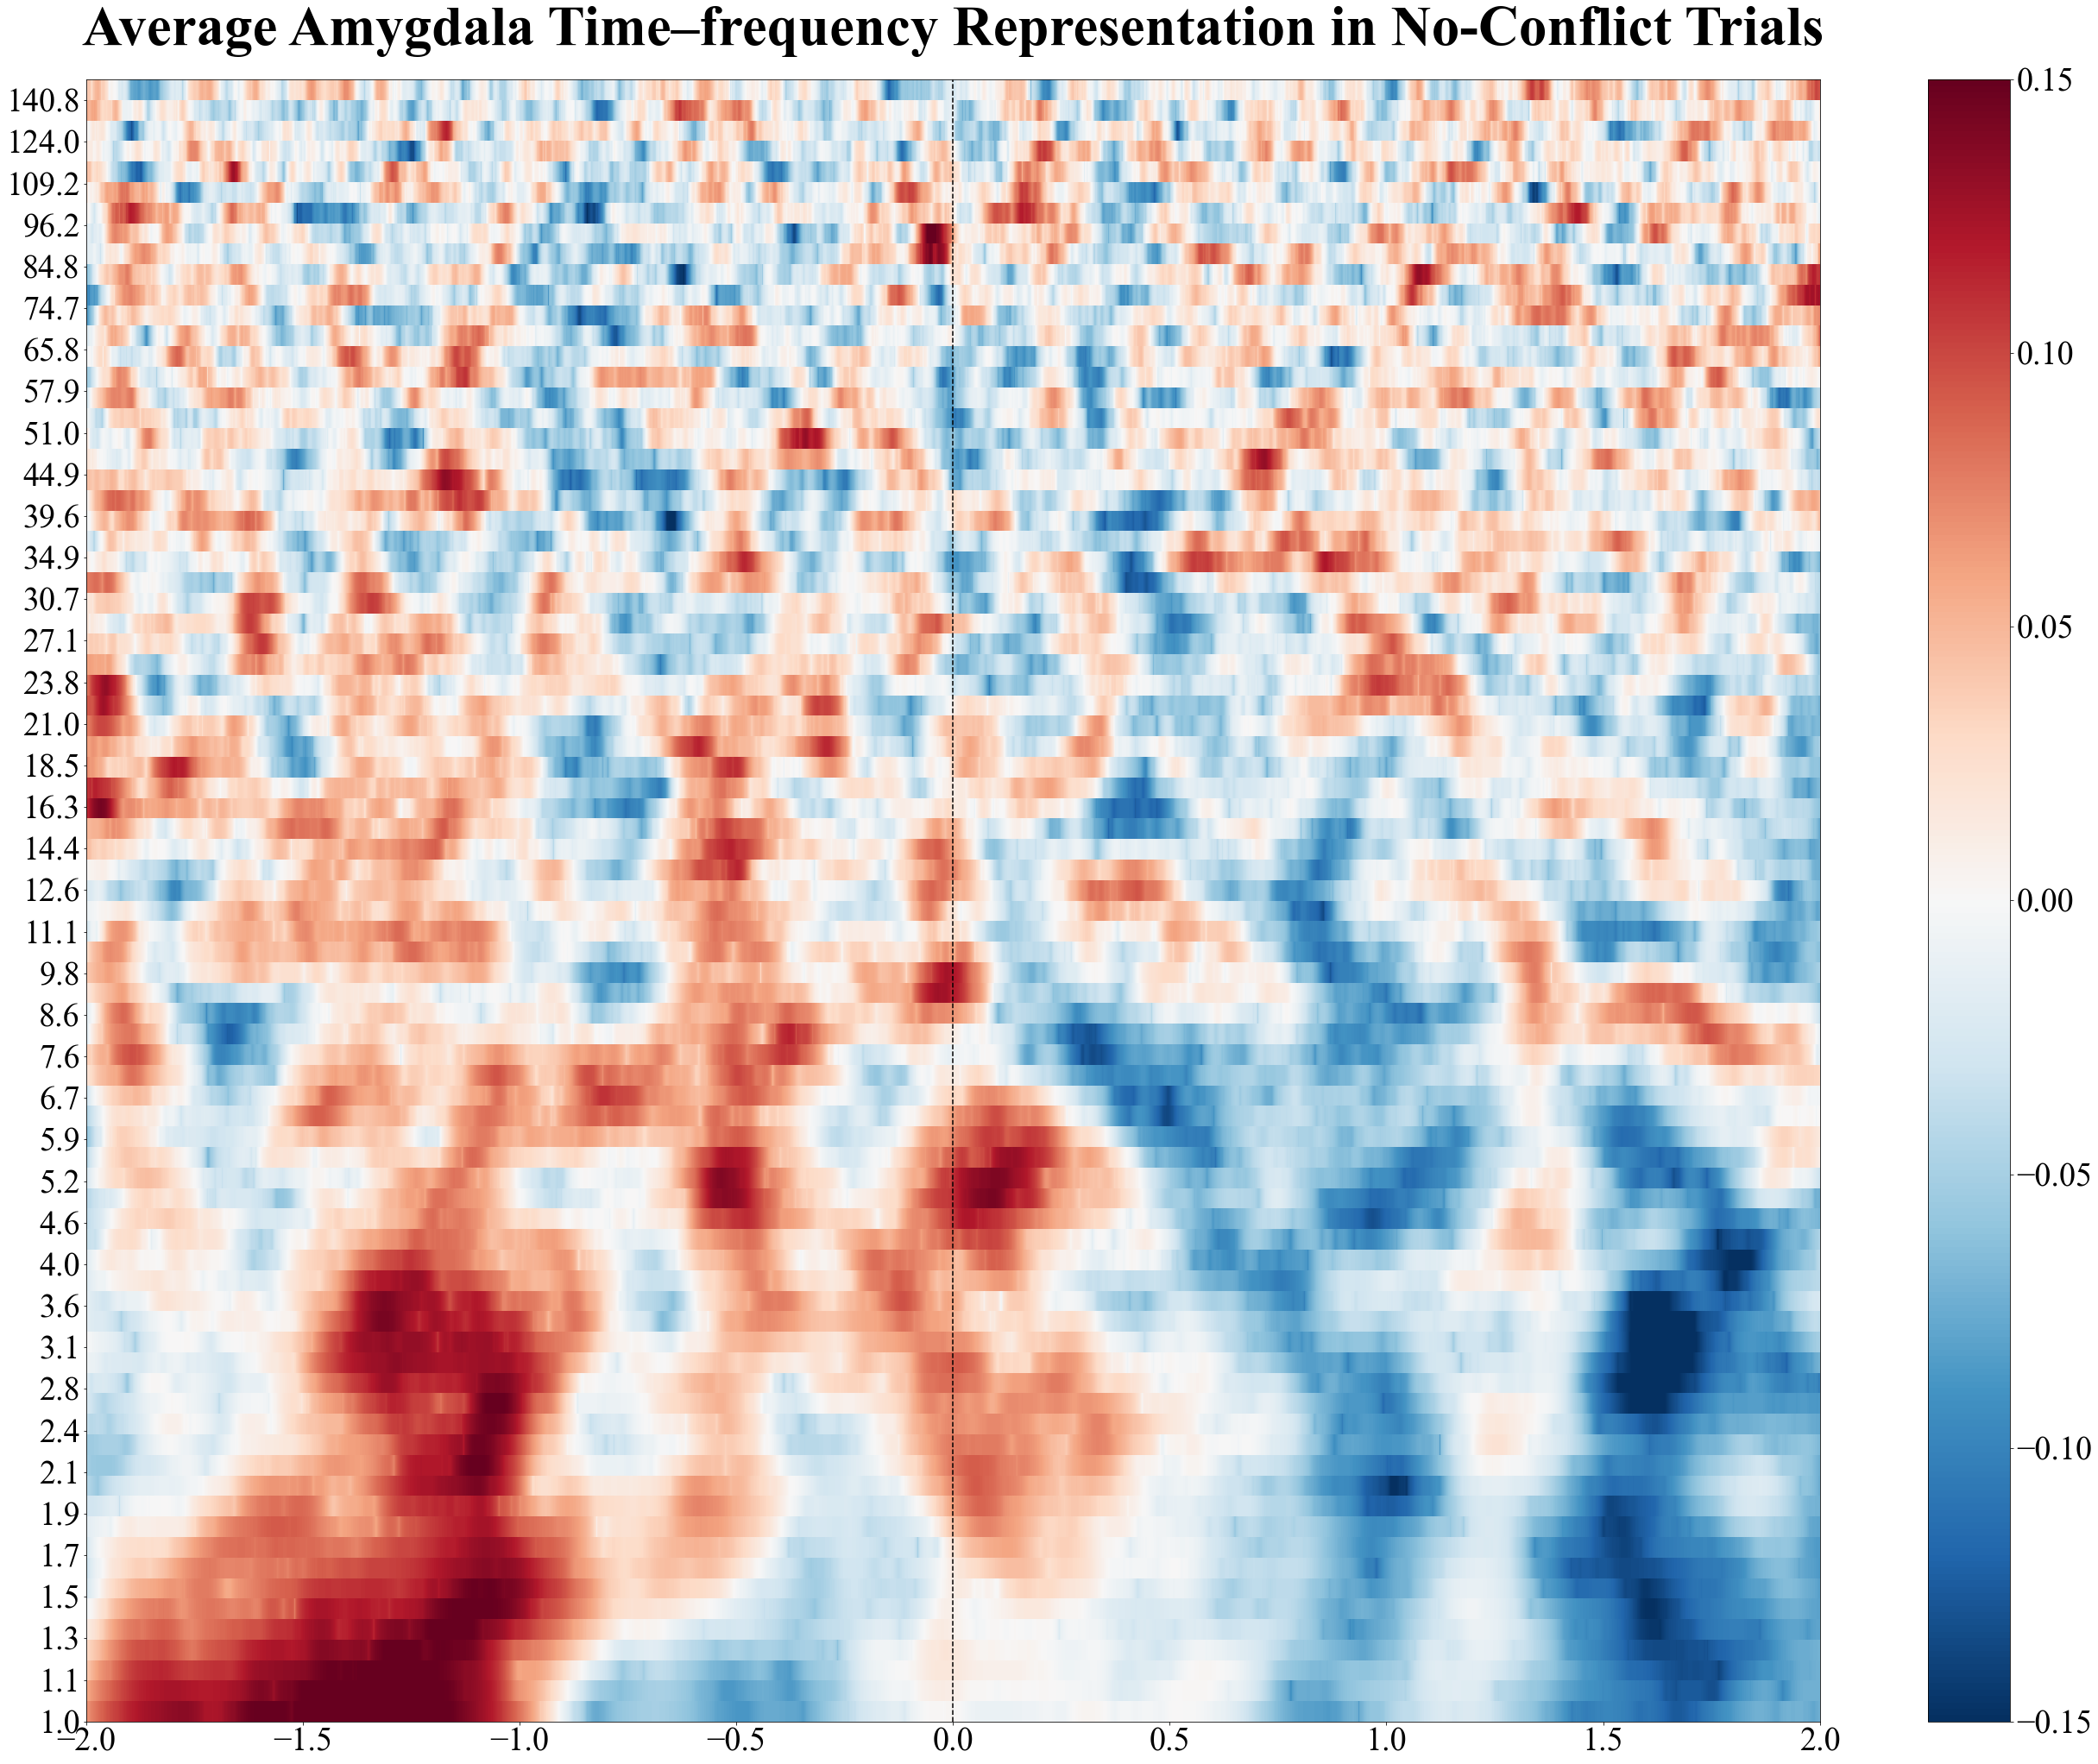

In [84]:
plot_allsub_averages(all_subs_noghost_average_amyg, "Average Amygdala Time–frequency Representation in No-Conflict Trials", 'average_amyg_noconflict_all_subs.png')

# Other Regions

## dlPFC

In [85]:
sub_list = ['SLCH002', 'BJH016', 'BJH021', 'BJH025', 'LL10', 'LL12', 'LL13']

all_subs_ghost_average_dlpfc, all_subs_noghost_average_dlpfc = calculate_last_away_average(sub_list, 'dlpfc')
    

Reading /home/brooke/pacman/preprocessing/SLCH002/ieeg/last_away/dlpfc_ghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/SLCH002/ieeg/last_away/dlpfc_noghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/BJH016/ieeg/last_away/dlpfc_ghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/BJH016/ieeg/last_away/dlpfc_noghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/BJH021/ieeg/last_away/dlpfc_ghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/BJH021/ieeg/last_away/dlpfc_noghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/BJH025/ieeg/last_away/dlpfc_ghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/BJH025/ieeg/last_away/dlpfc_noghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/LL10

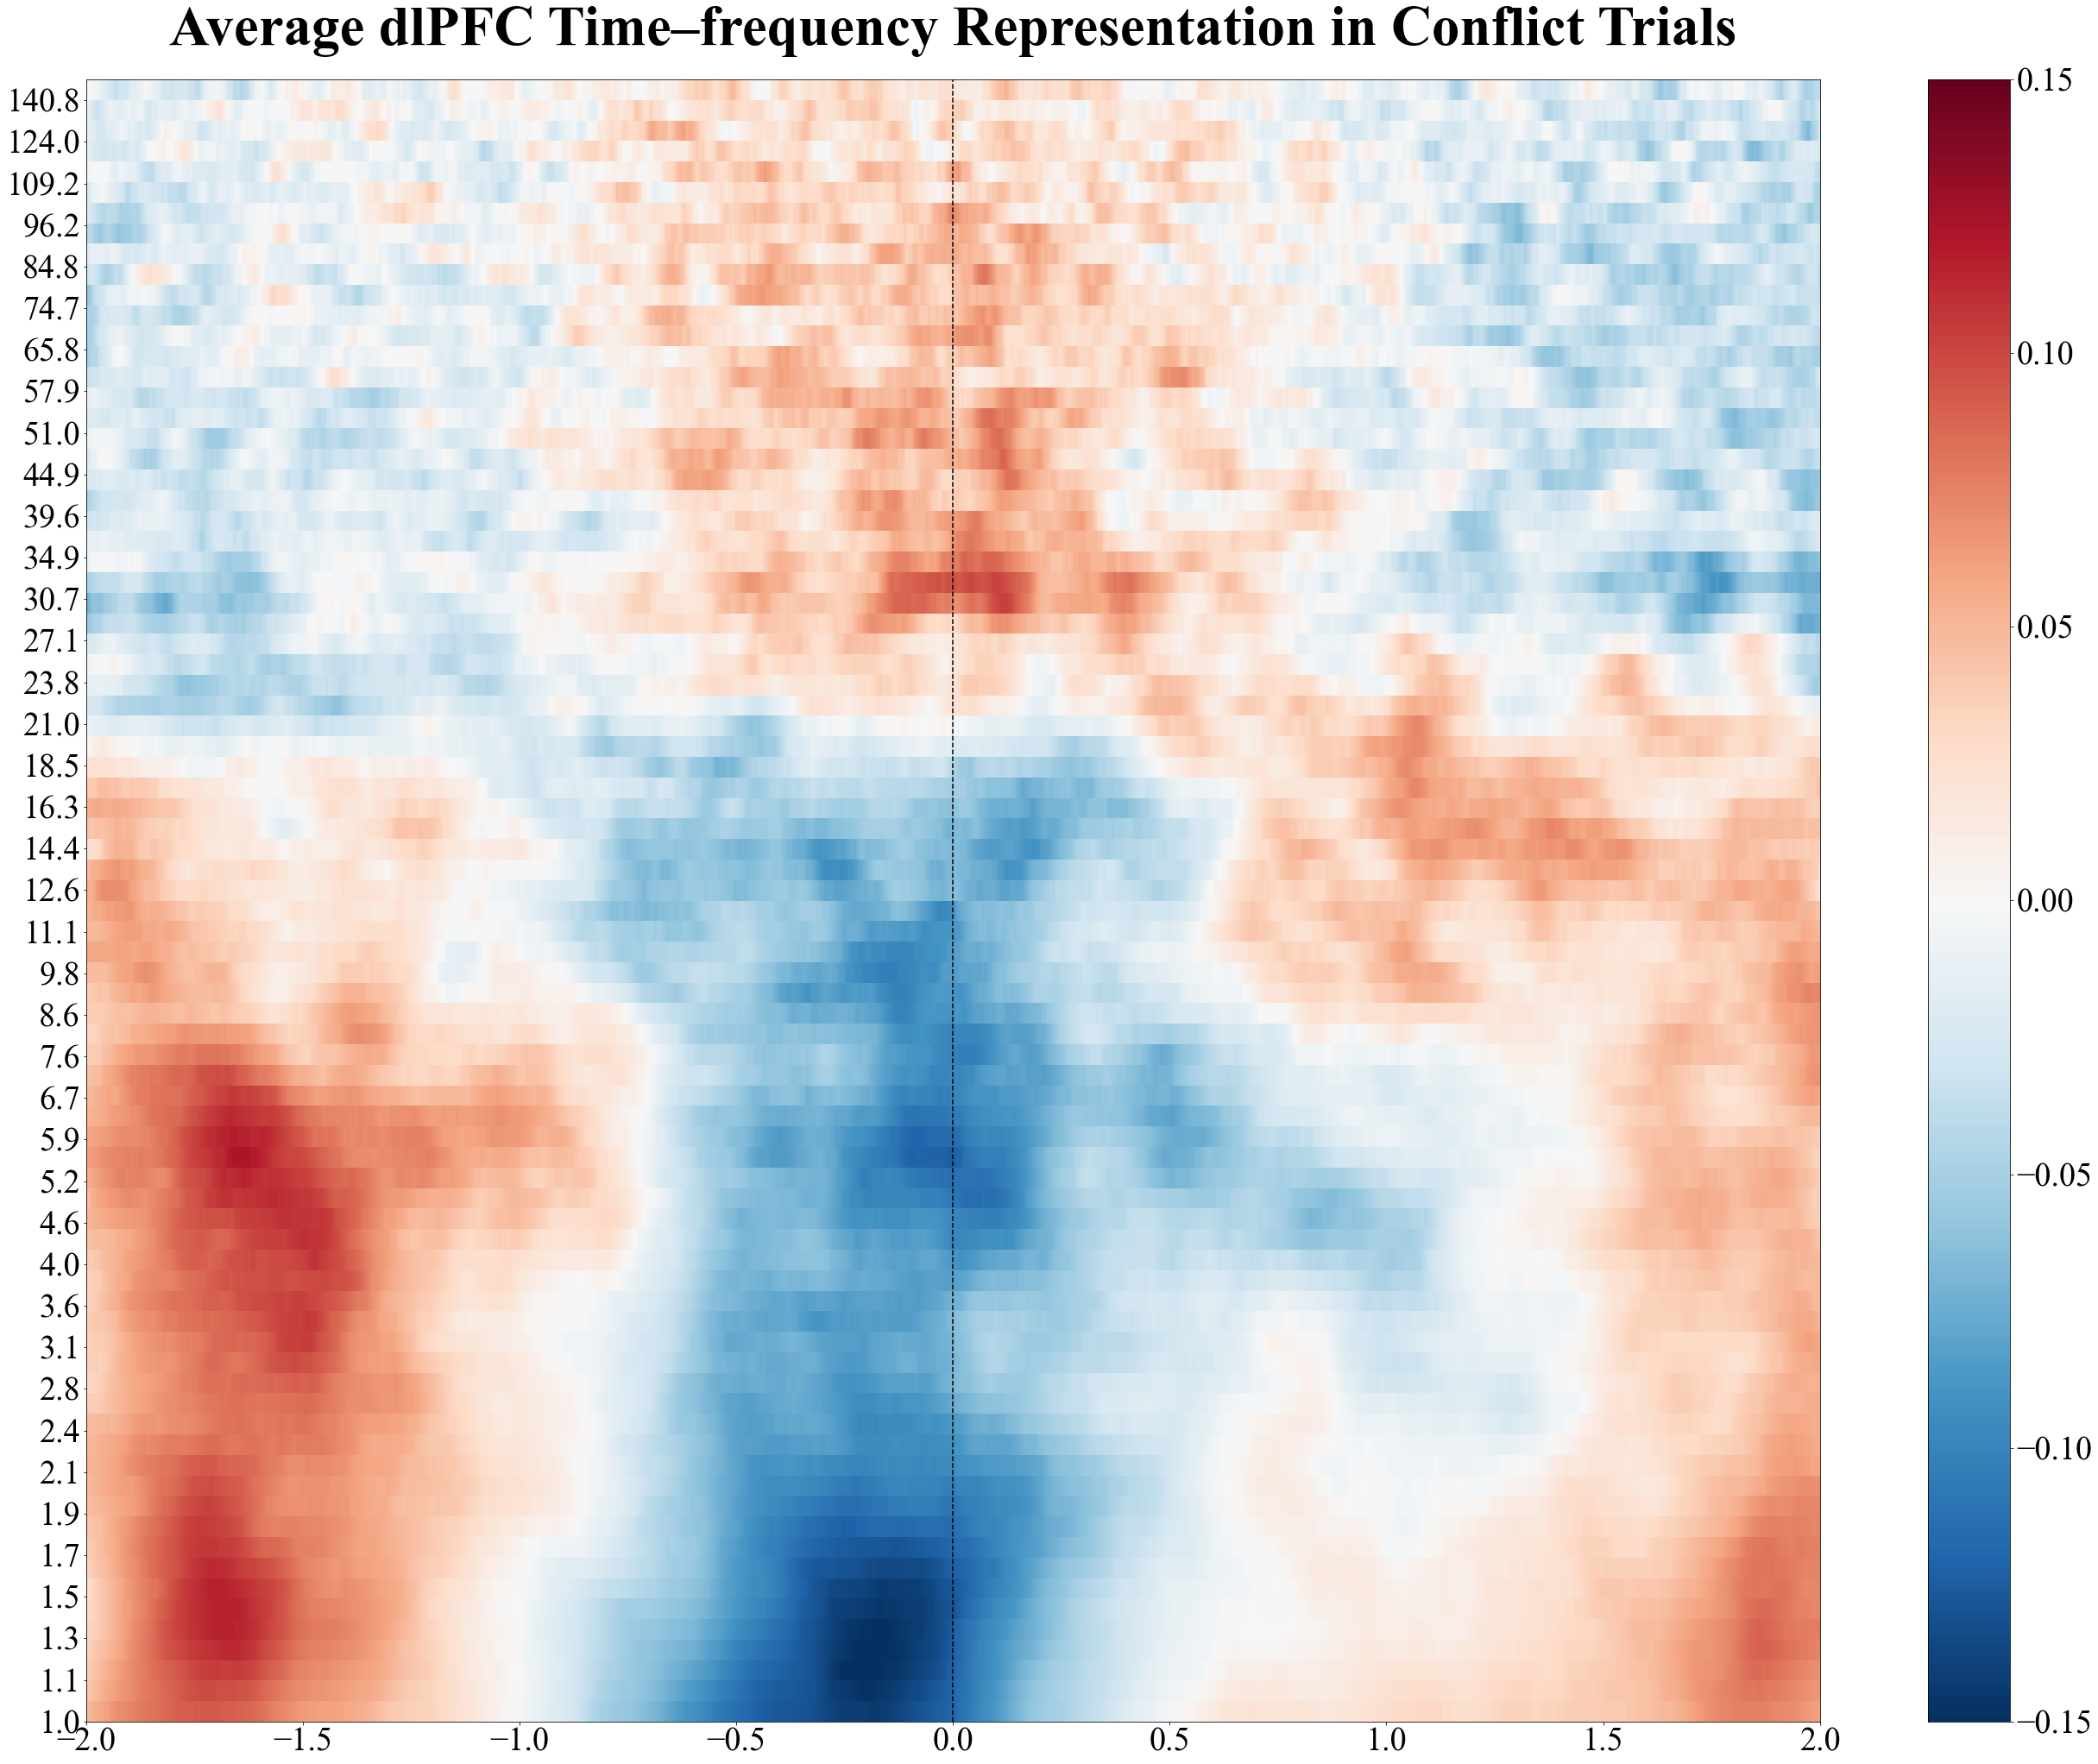

In [86]:
plot_allsub_averages(all_subs_ghost_average_dlpfc, "Average dlPFC Time–frequency Representation in Conflict Trials", 'average_dlpfc_conflict_all_subs.png')

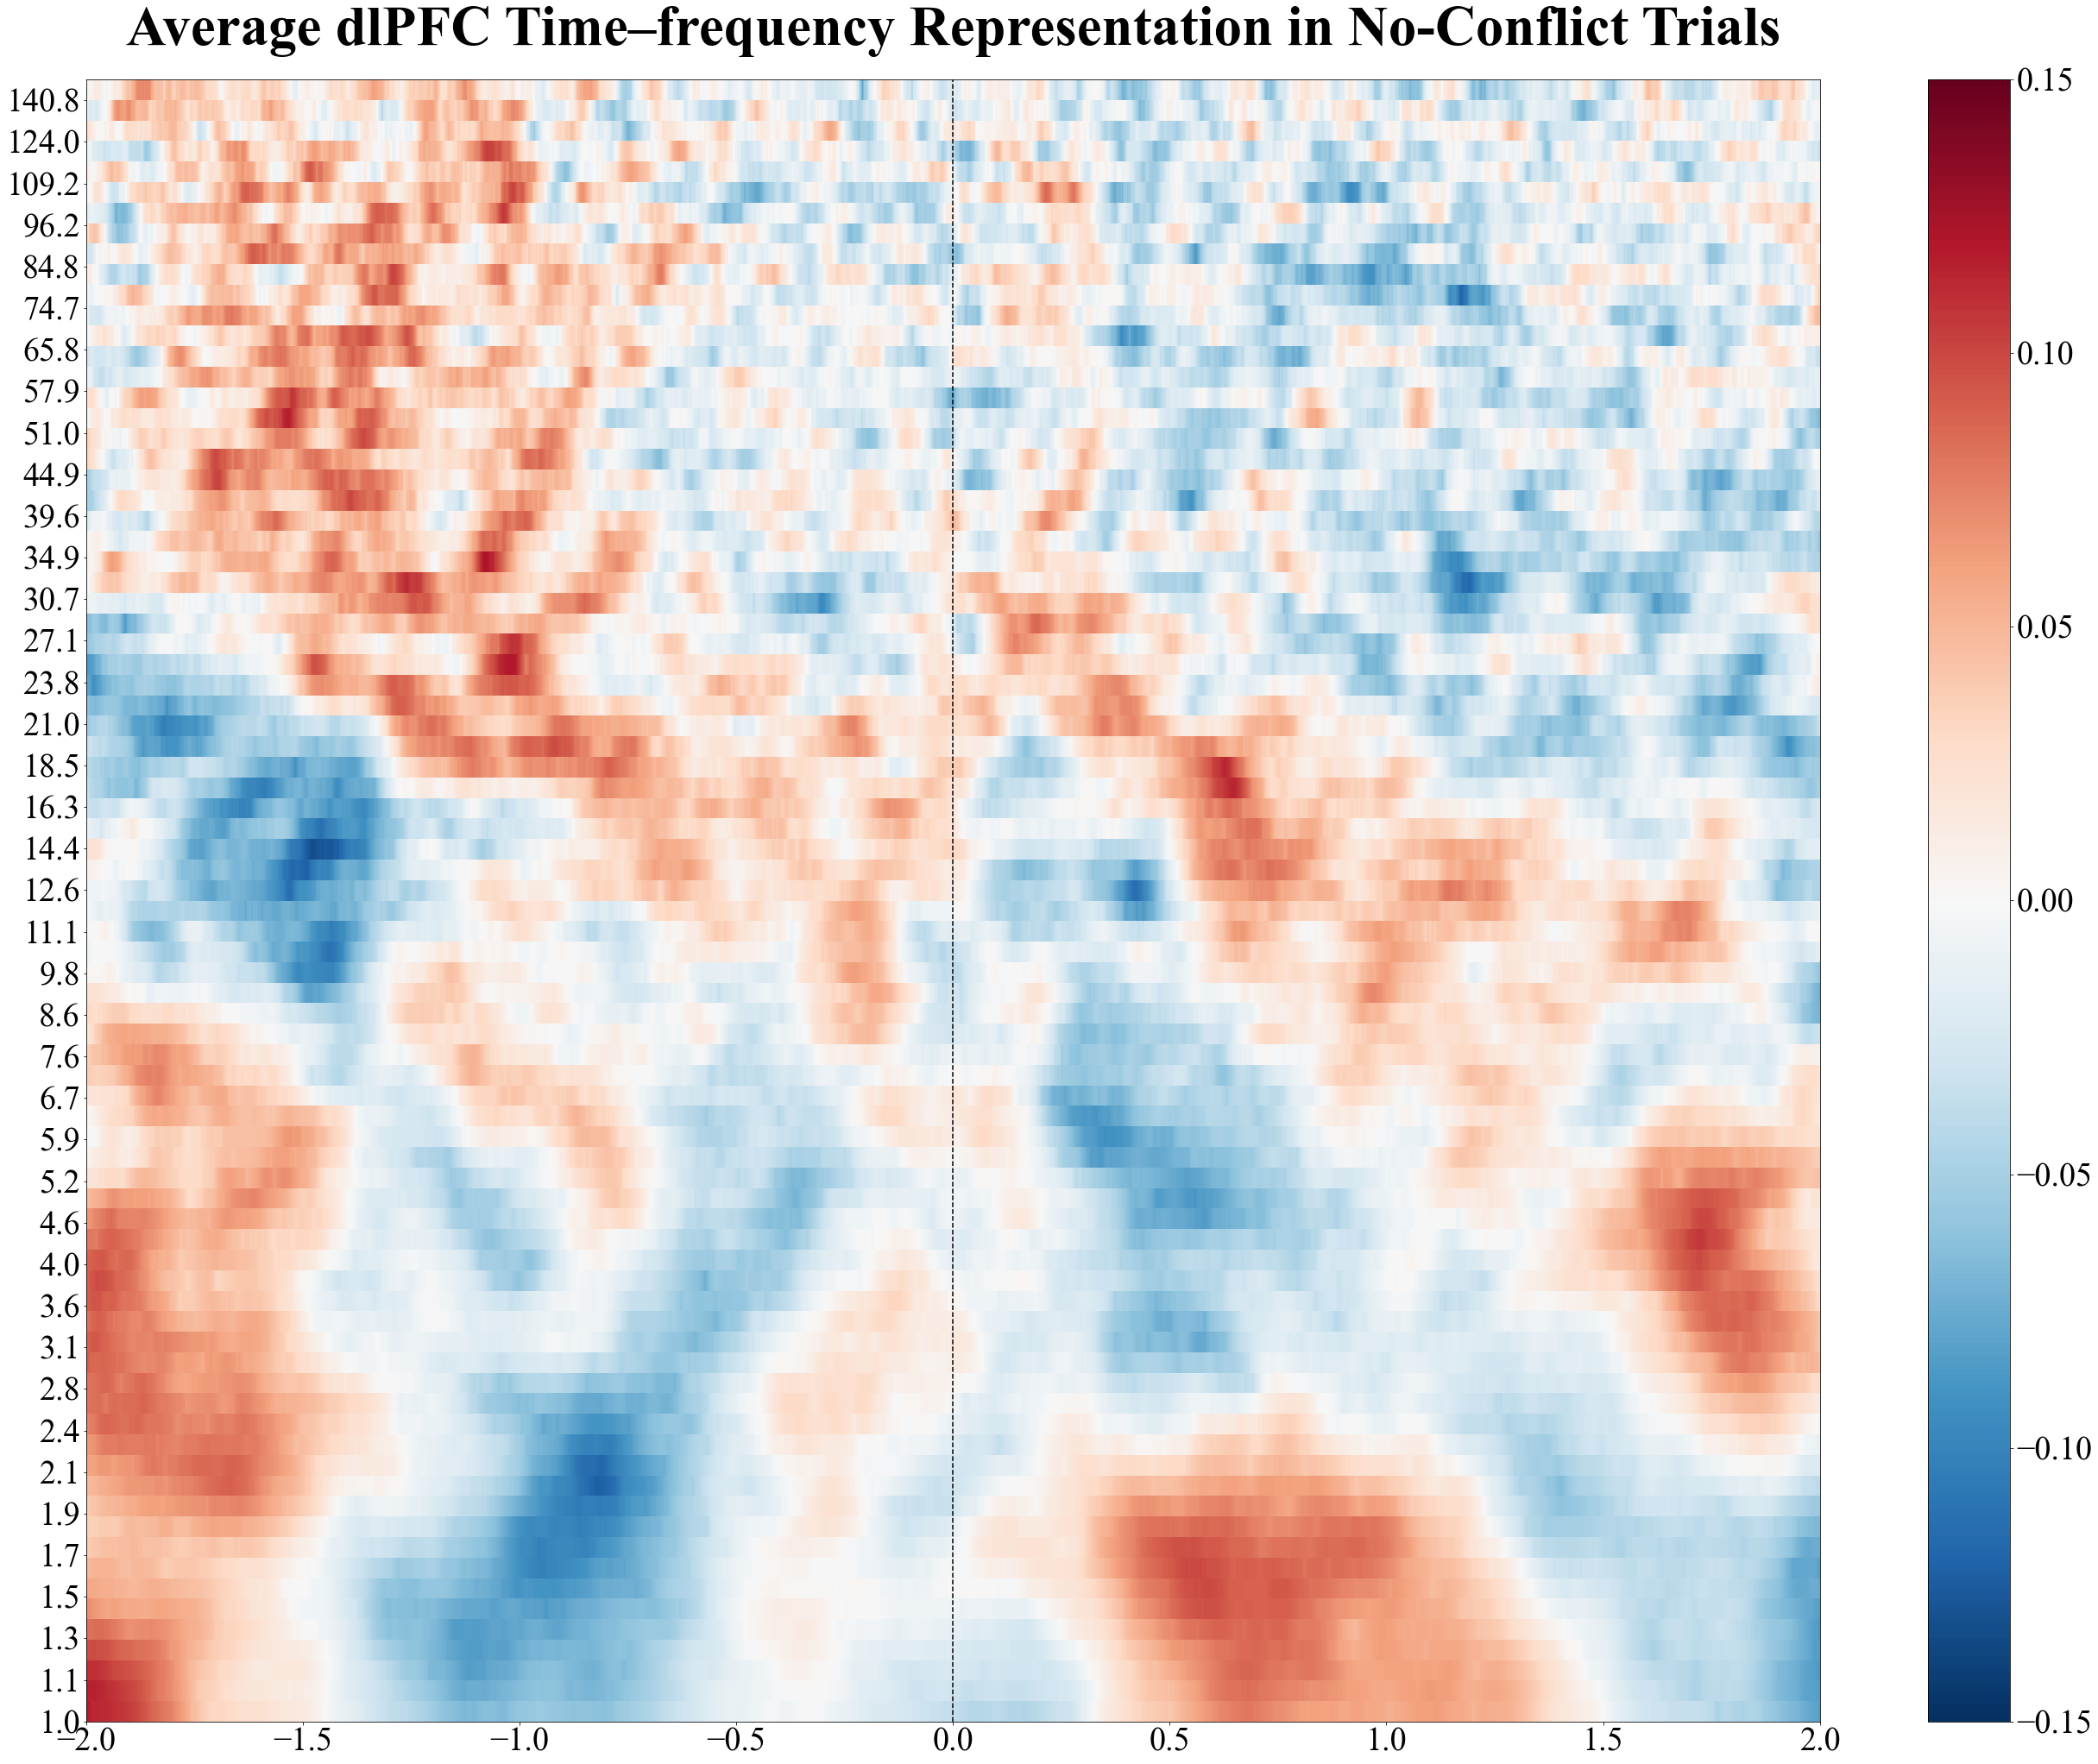

In [87]:
plot_allsub_averages(all_subs_noghost_average_dlpfc, "Average dlPFC Time–frequency Representation in No-Conflict Trials", 'average_dlpfc_noconflict_all_subs.png')

## Insula

In [107]:
sub_list = ['SLCH002', 'BJH016', 'BJH021', 'BJH025', 'LL12']

all_subs_ghost_average_insula, all_subs_noghost_average_insula = calculate_last_away_average(sub_list, 'insula')
    

> /tmp/ipykernel_159888/219573767.py(36)calculate_last_away_average()
     34 
     35         # combine
---> 36         all_subs_ghost = np.stack((washu_ghost_tfrs_mean[:, ::2], ll_ghost_tfrs_mean[:, 0:2001]))
     37         all_subs_noghost = np.stack((washu_no_ghost_tfrs_mean[:, ::2], ll_no_ghost_tfrs_mean[:, 0:2001]))
     38 



ipdb>  quit()


Reading /home/brooke/pacman/preprocessing/SLCH002/ieeg/last_away/insula_ghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/SLCH002/ieeg/last_away/insula_noghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/BJH016/ieeg/last_away/insula_ghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/BJH016/ieeg/last_away/insula_noghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/BJH021/ieeg/last_away/insula_ghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/BJH021/ieeg/last_away/insula_noghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/BJH025/ieeg/last_away/insula_ghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/BJH025/ieeg/last_away/insula_noghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocess

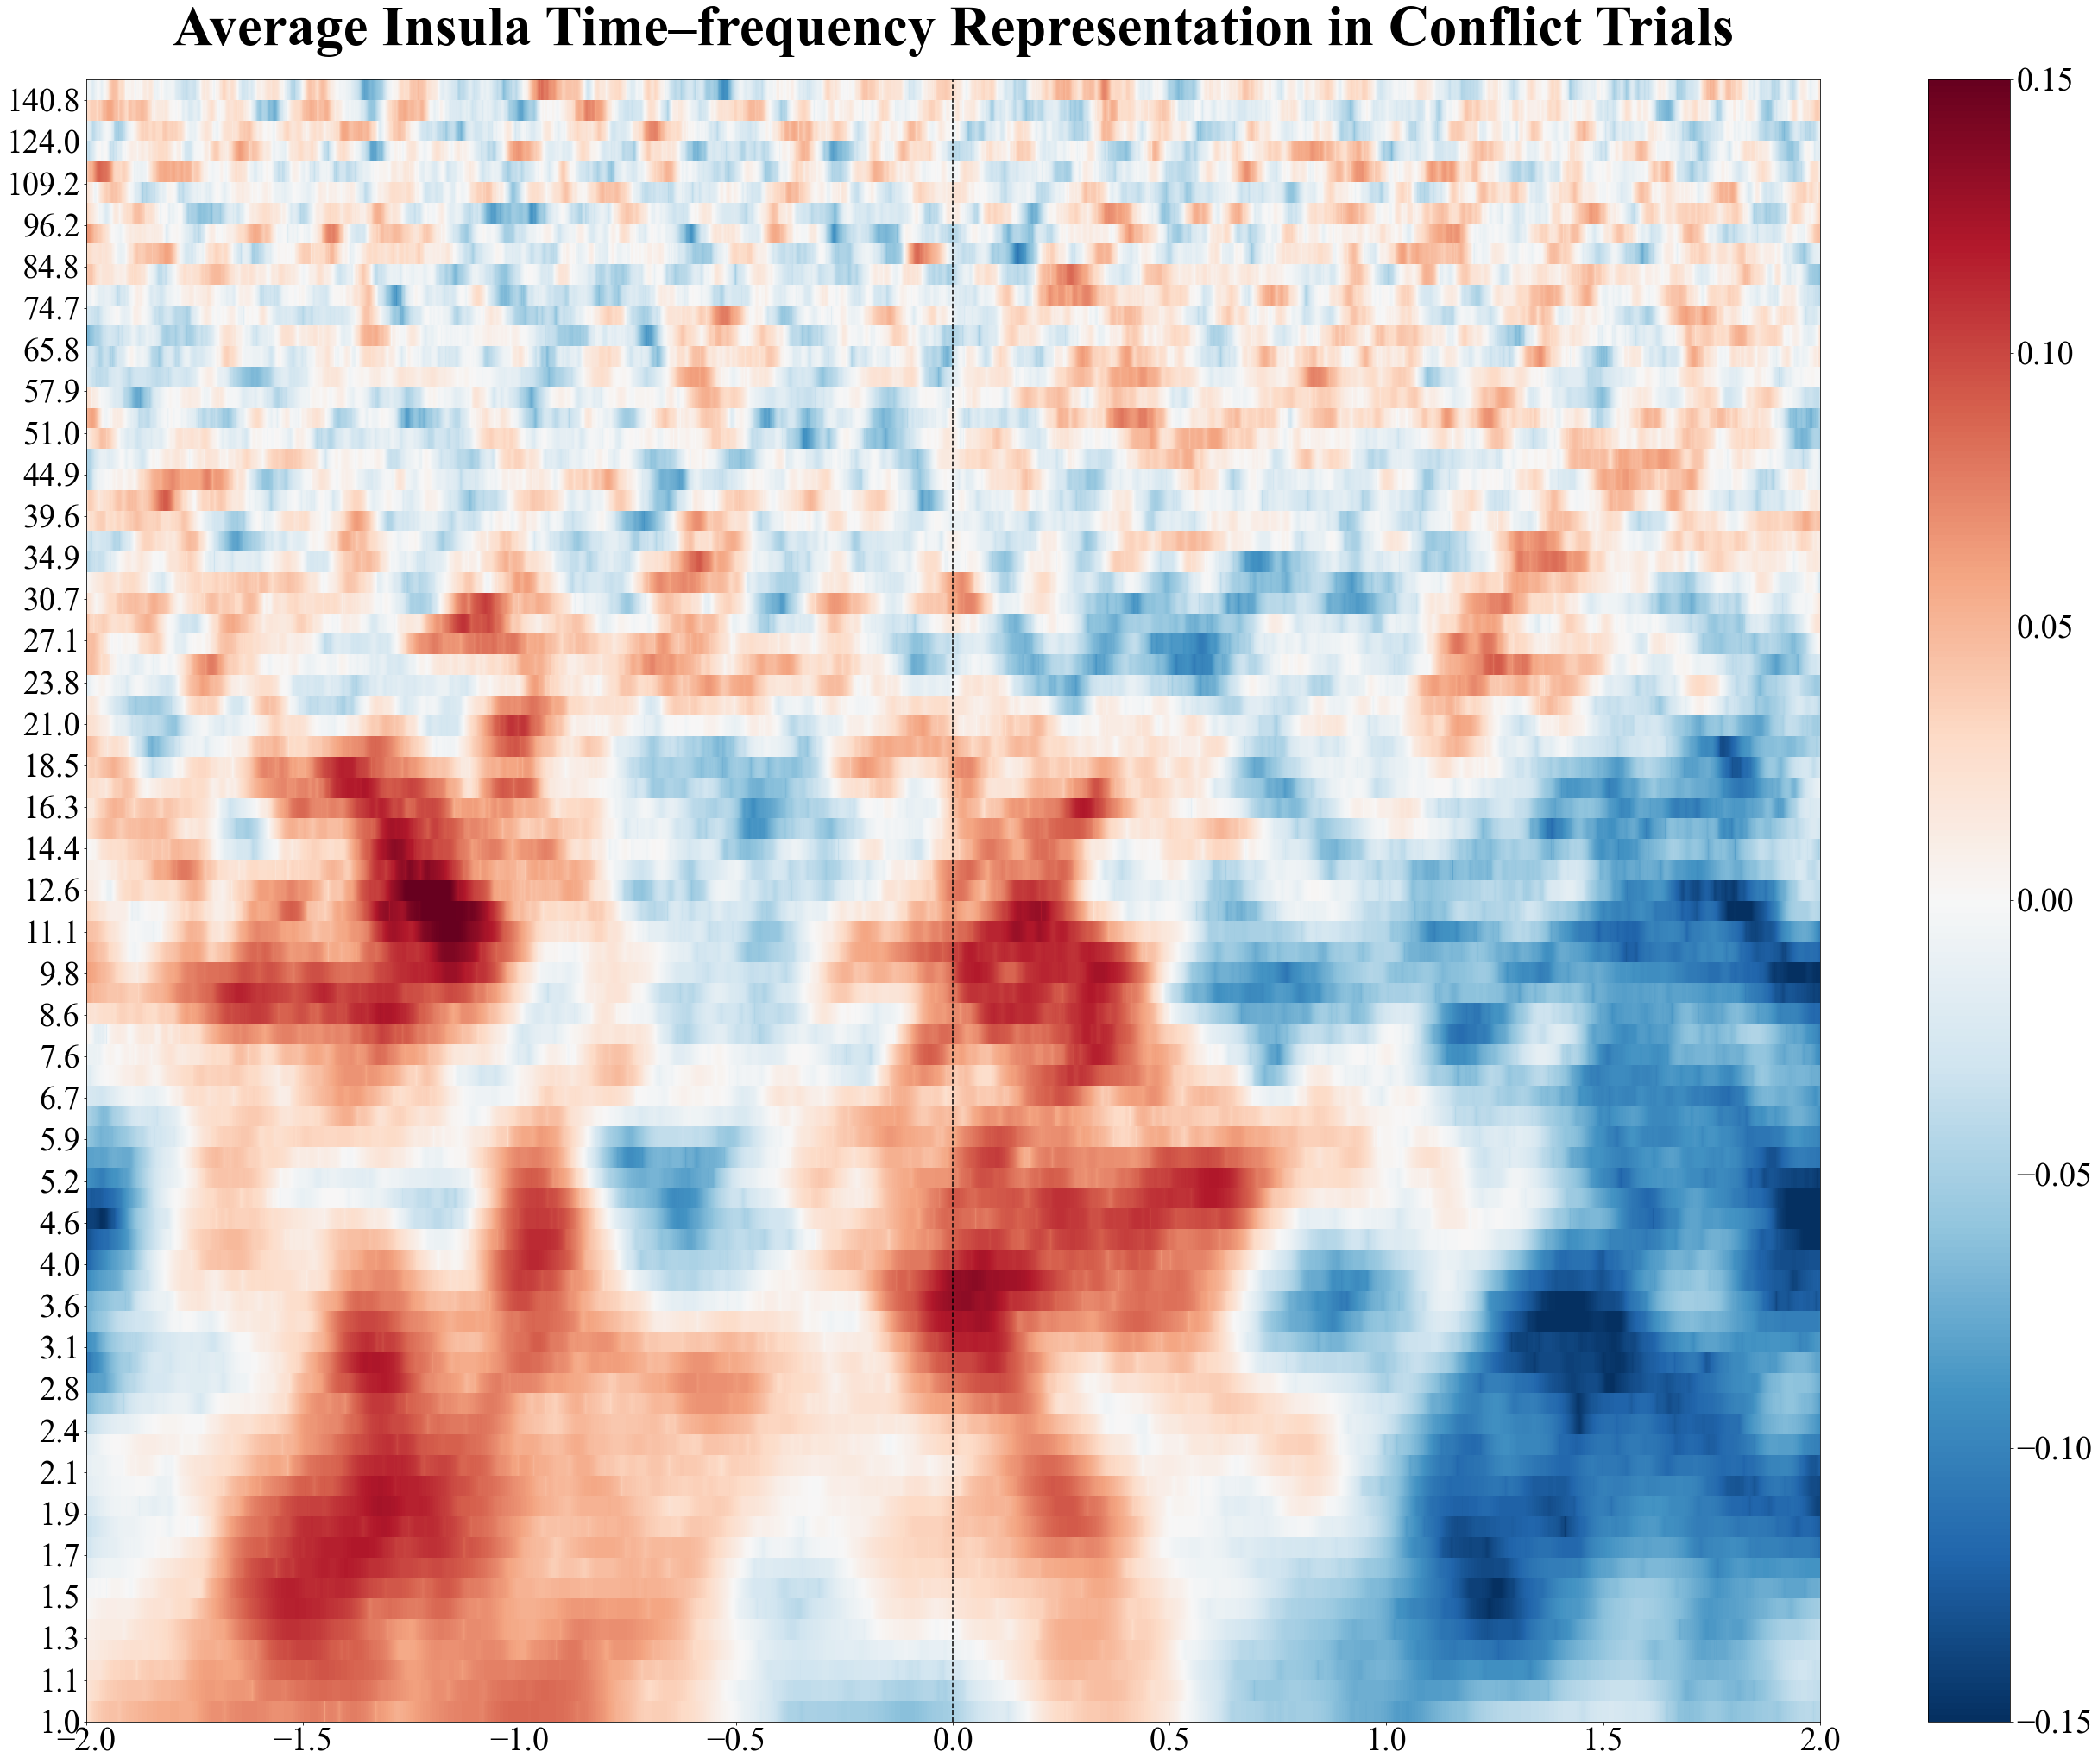

In [108]:
plot_allsub_averages(all_subs_ghost_average_insula, "Average Insula Time–frequency Representation in Conflict Trials", 'average_insula_conflict_all_subs.png')

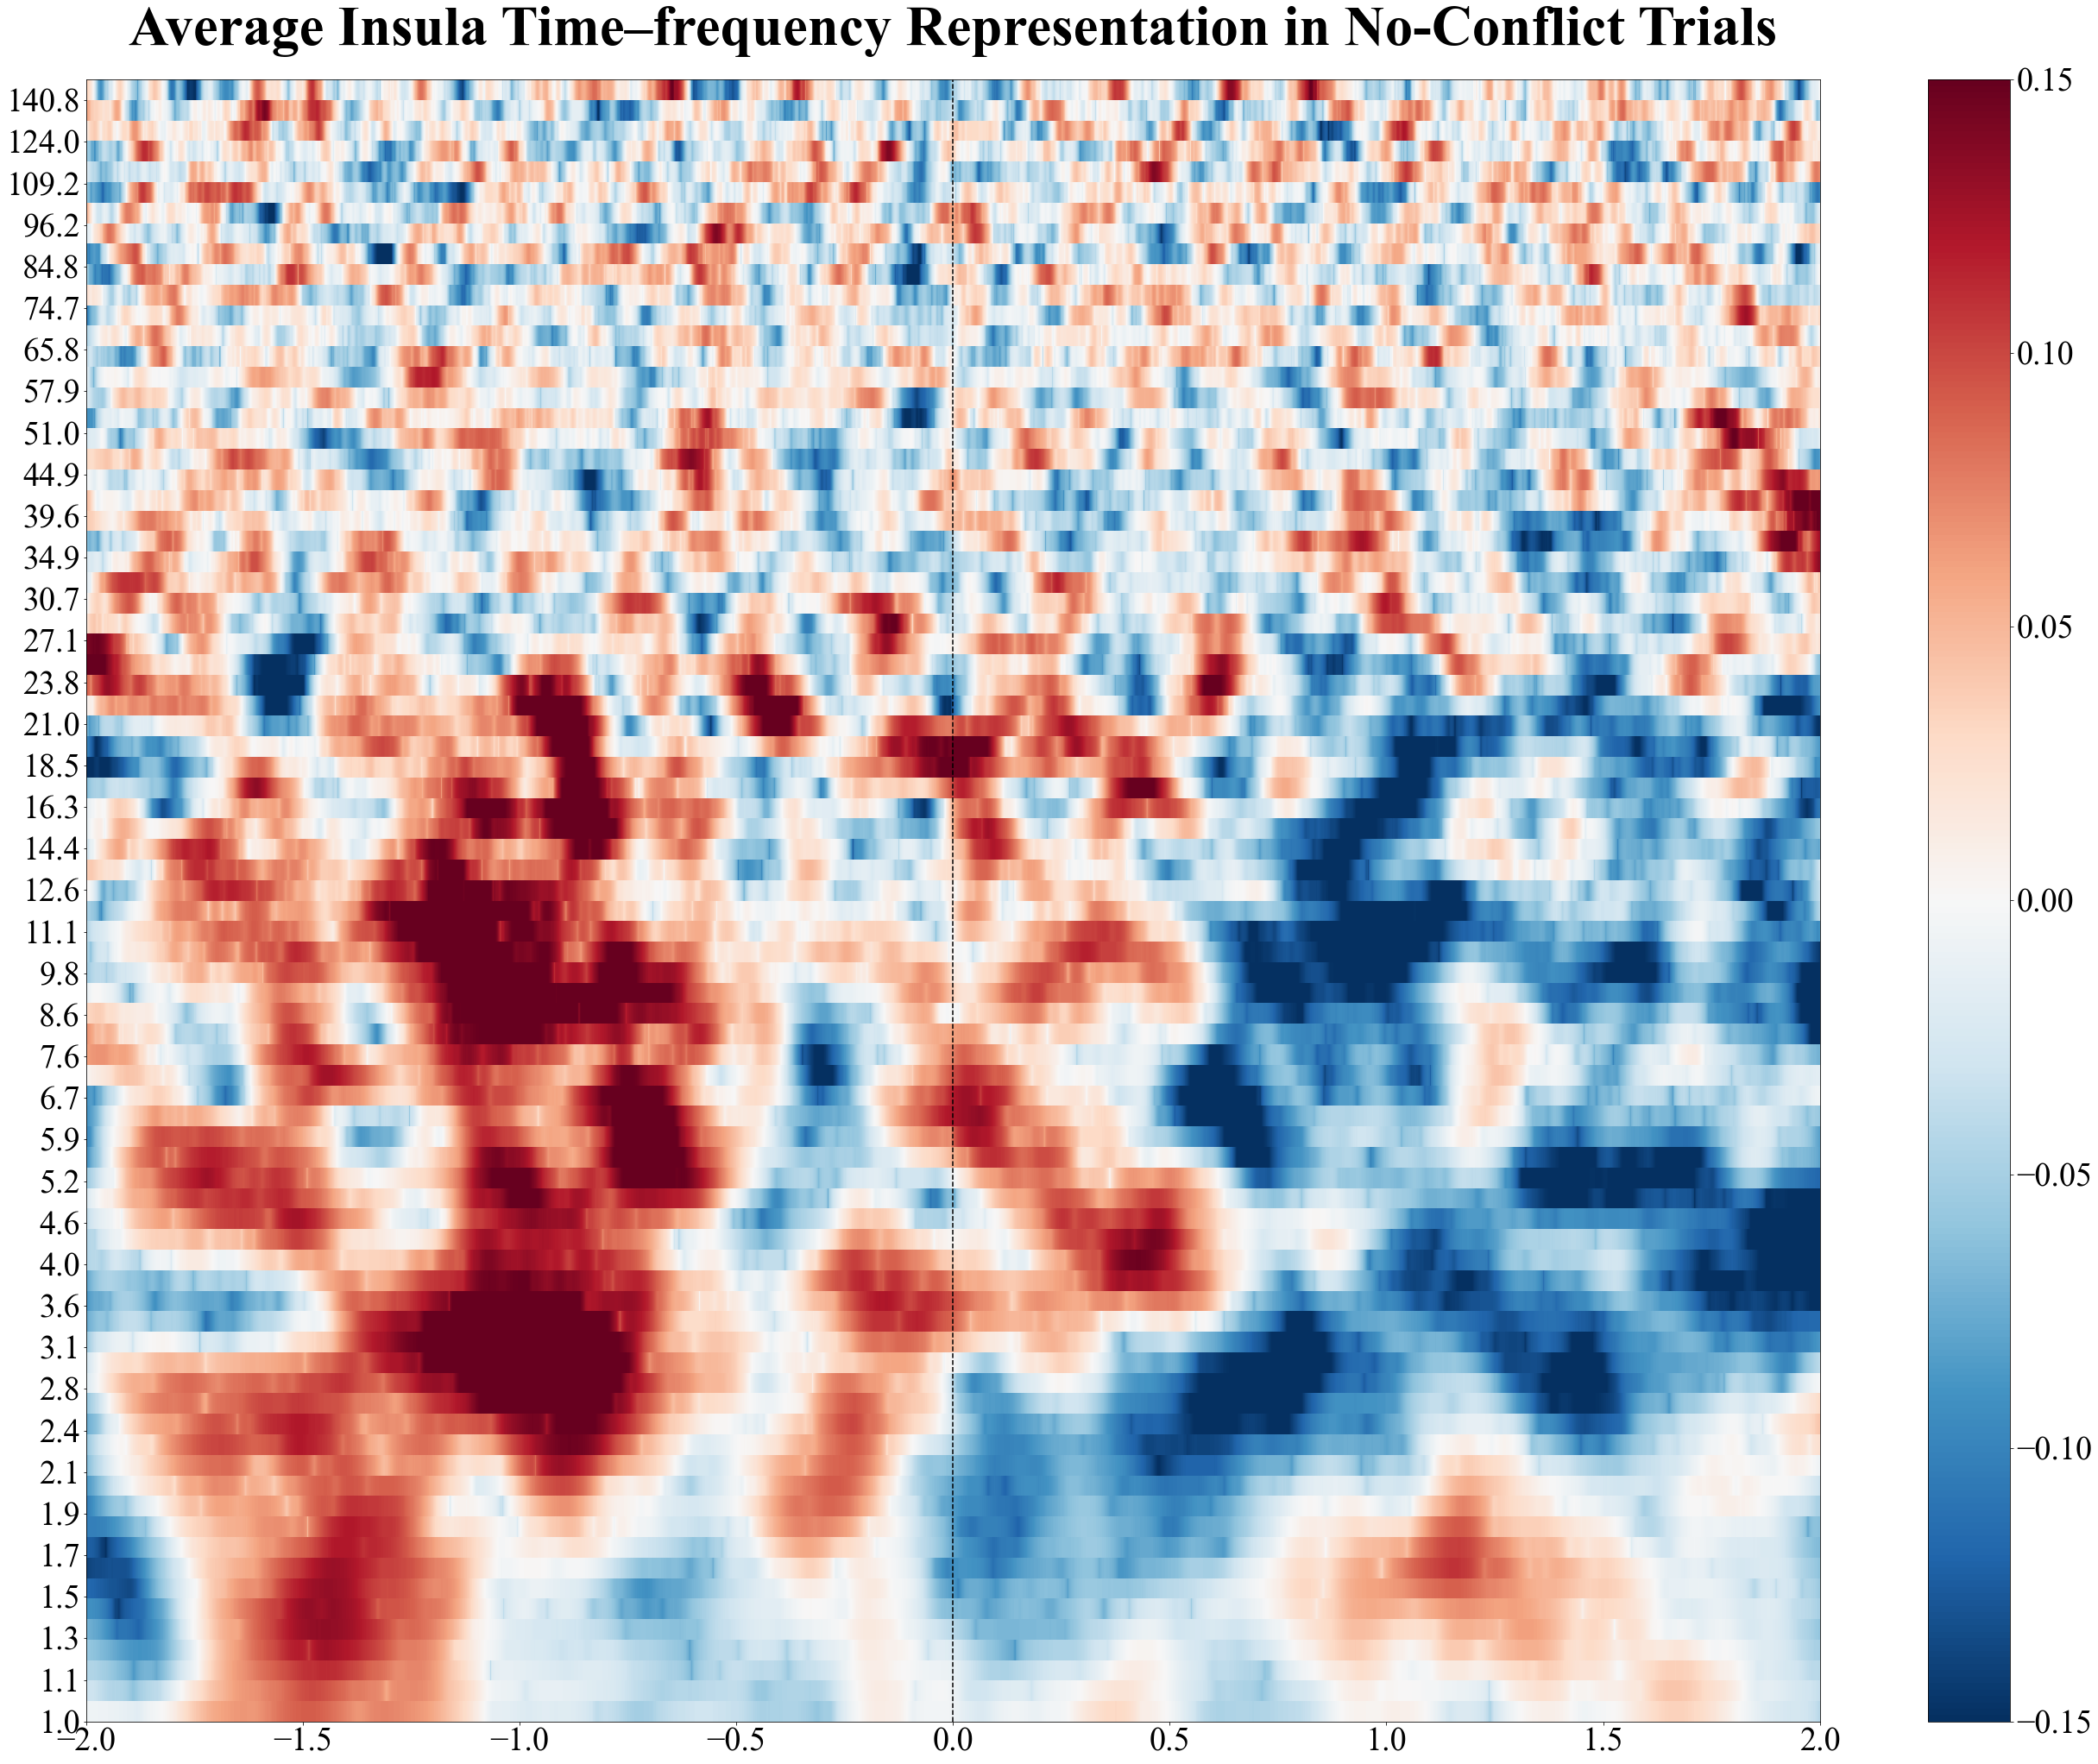

In [109]:
plot_allsub_averages(all_subs_noghost_average_insula, "Average Insula Time–frequency Representation in No-Conflict Trials", 'average_insula_noconflict_all_subs.png')

## EC

In [114]:
sub_list = ['SLCH002', 'BJH016', 'BJH025']

all_subs_ghost_average_ec, all_subs_noghost_average_ec = calculate_last_away_average(sub_list, 'ec')
    

Reading /home/brooke/pacman/preprocessing/SLCH002/ieeg/last_away/ec_ghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/SLCH002/ieeg/last_away/ec_noghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/BJH016/ieeg/last_away/ec_ghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/BJH016/ieeg/last_away/ec_noghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/BJH025/ieeg/last_away/ec_ghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/pacman/preprocessing/BJH025/ieeg/last_away/ec_noghost-tfr.h5 ...
Adding metadata with 5 columns


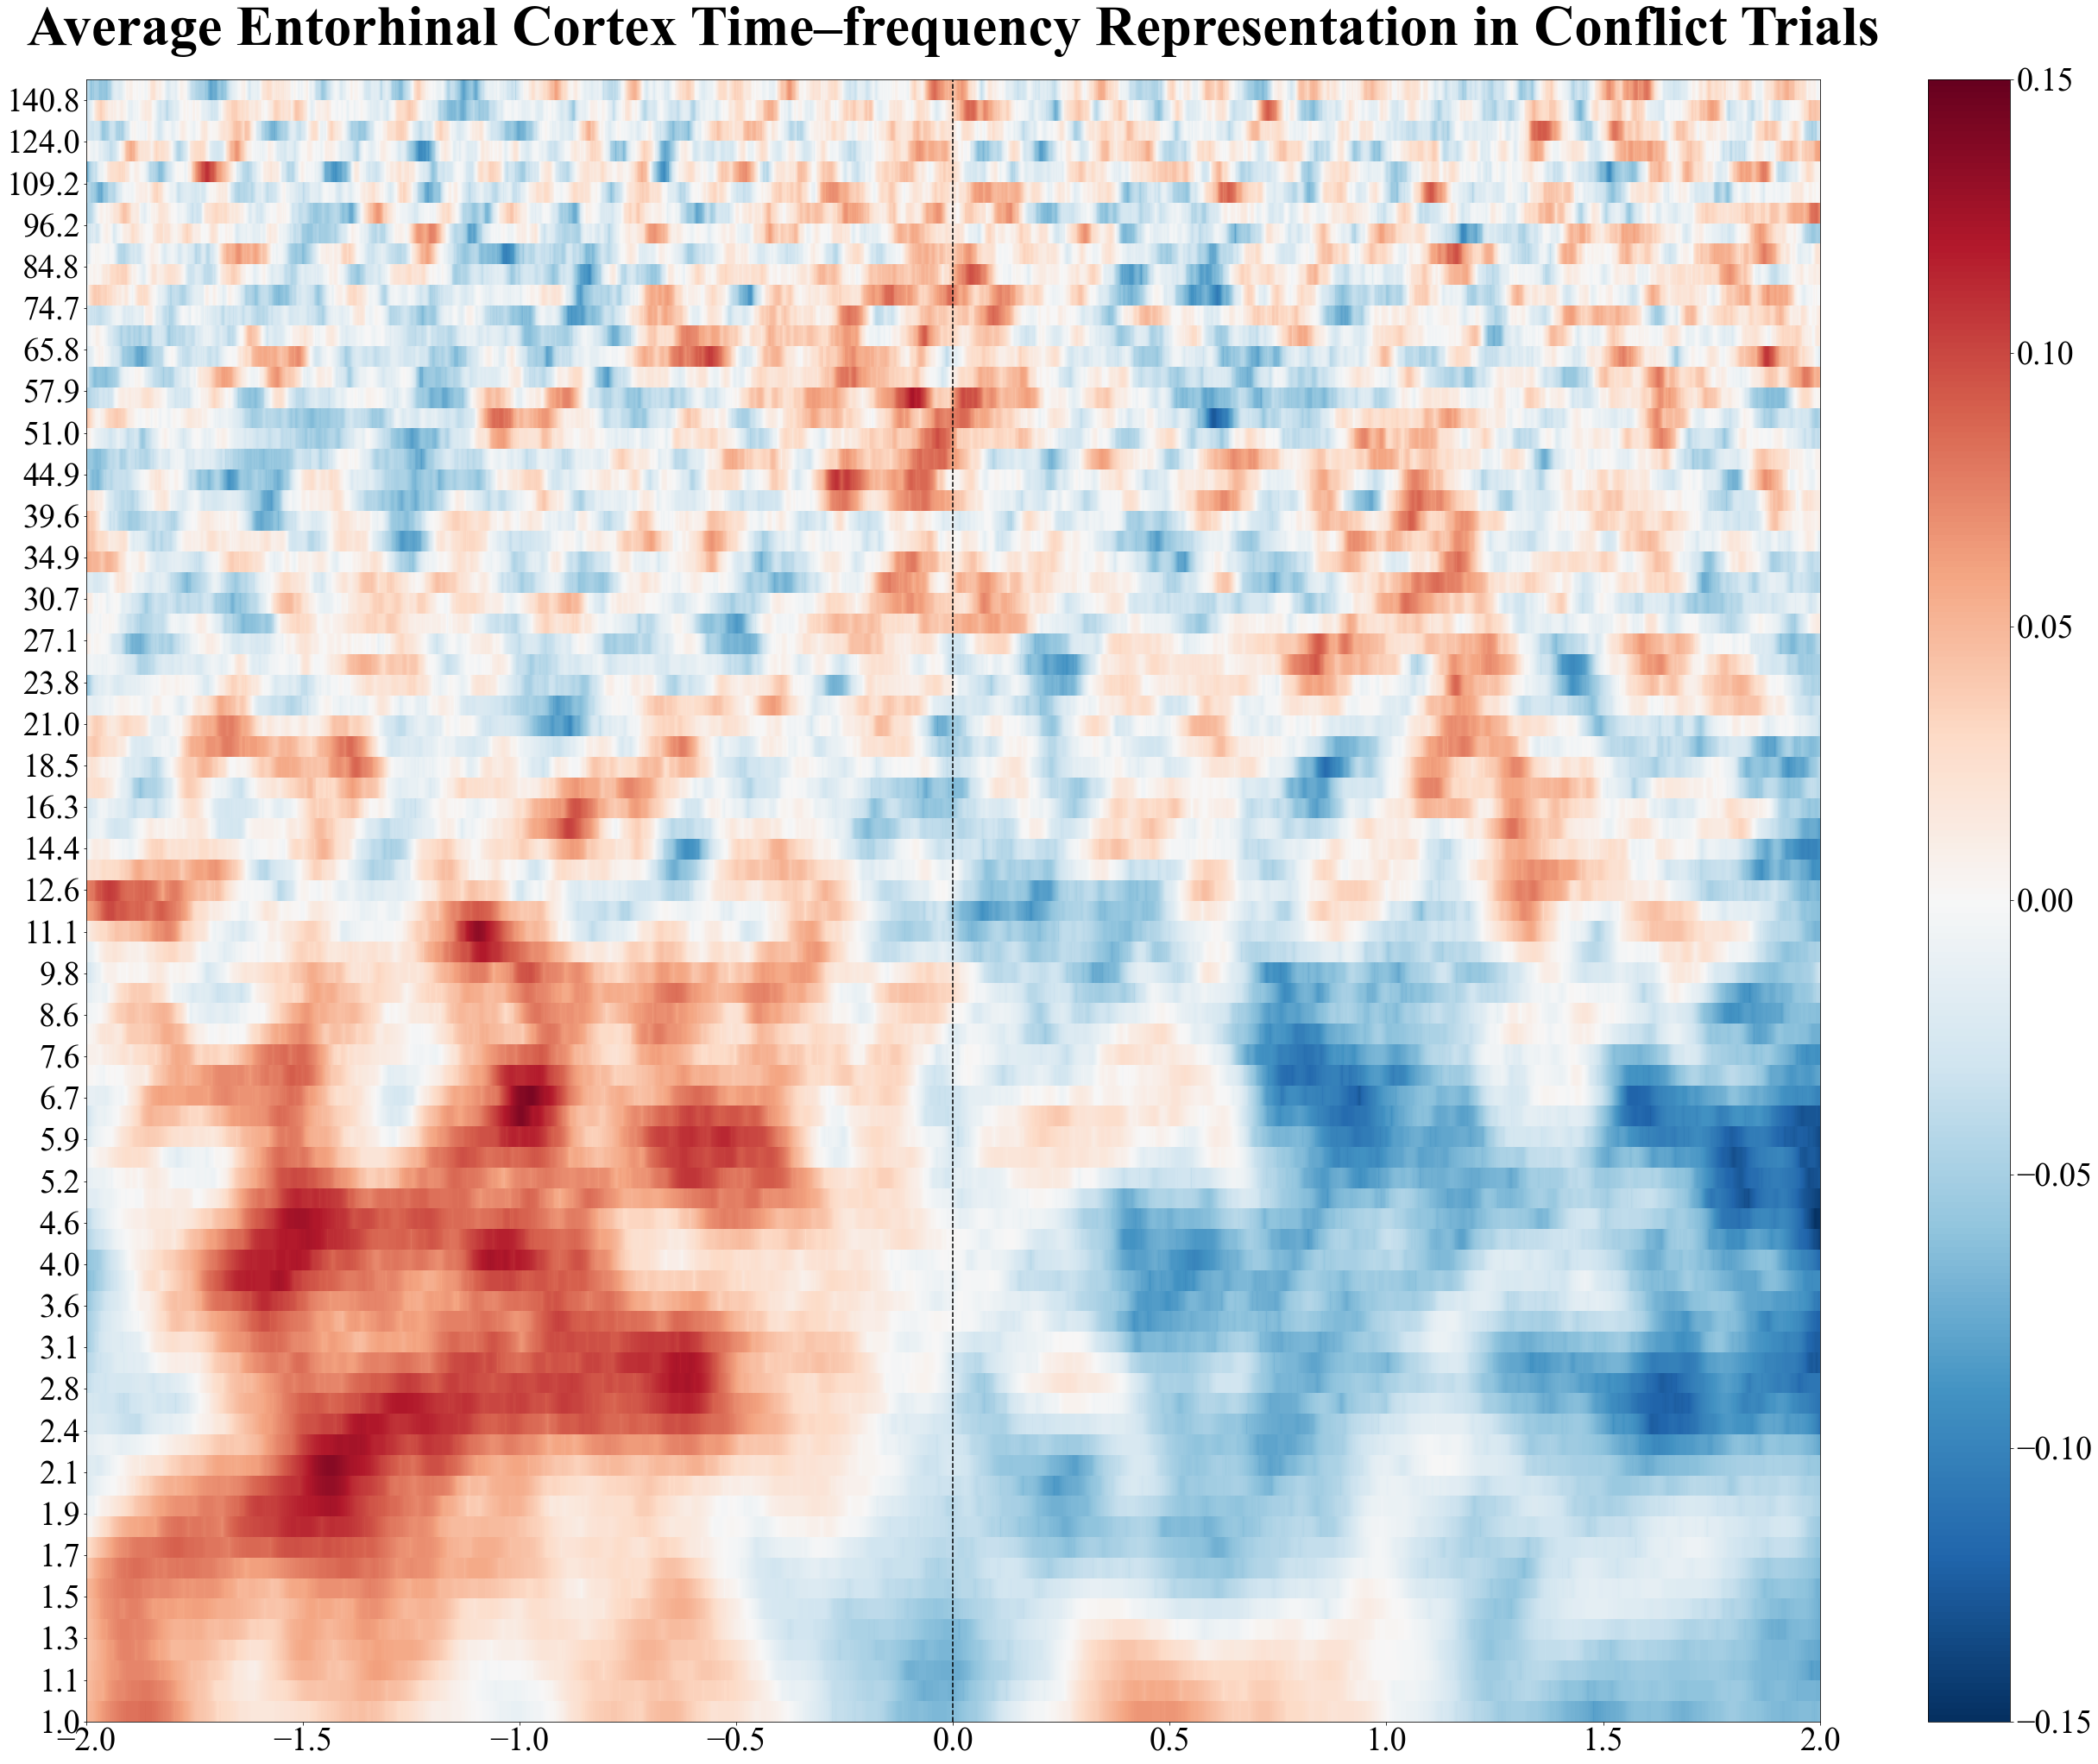

In [111]:
plot_allsub_averages(all_subs_ghost_average_ec, "Average Entorhinal Cortex Time–frequency Representation in Conflict Trials", 'average_ec_conflict_all_subs.png')

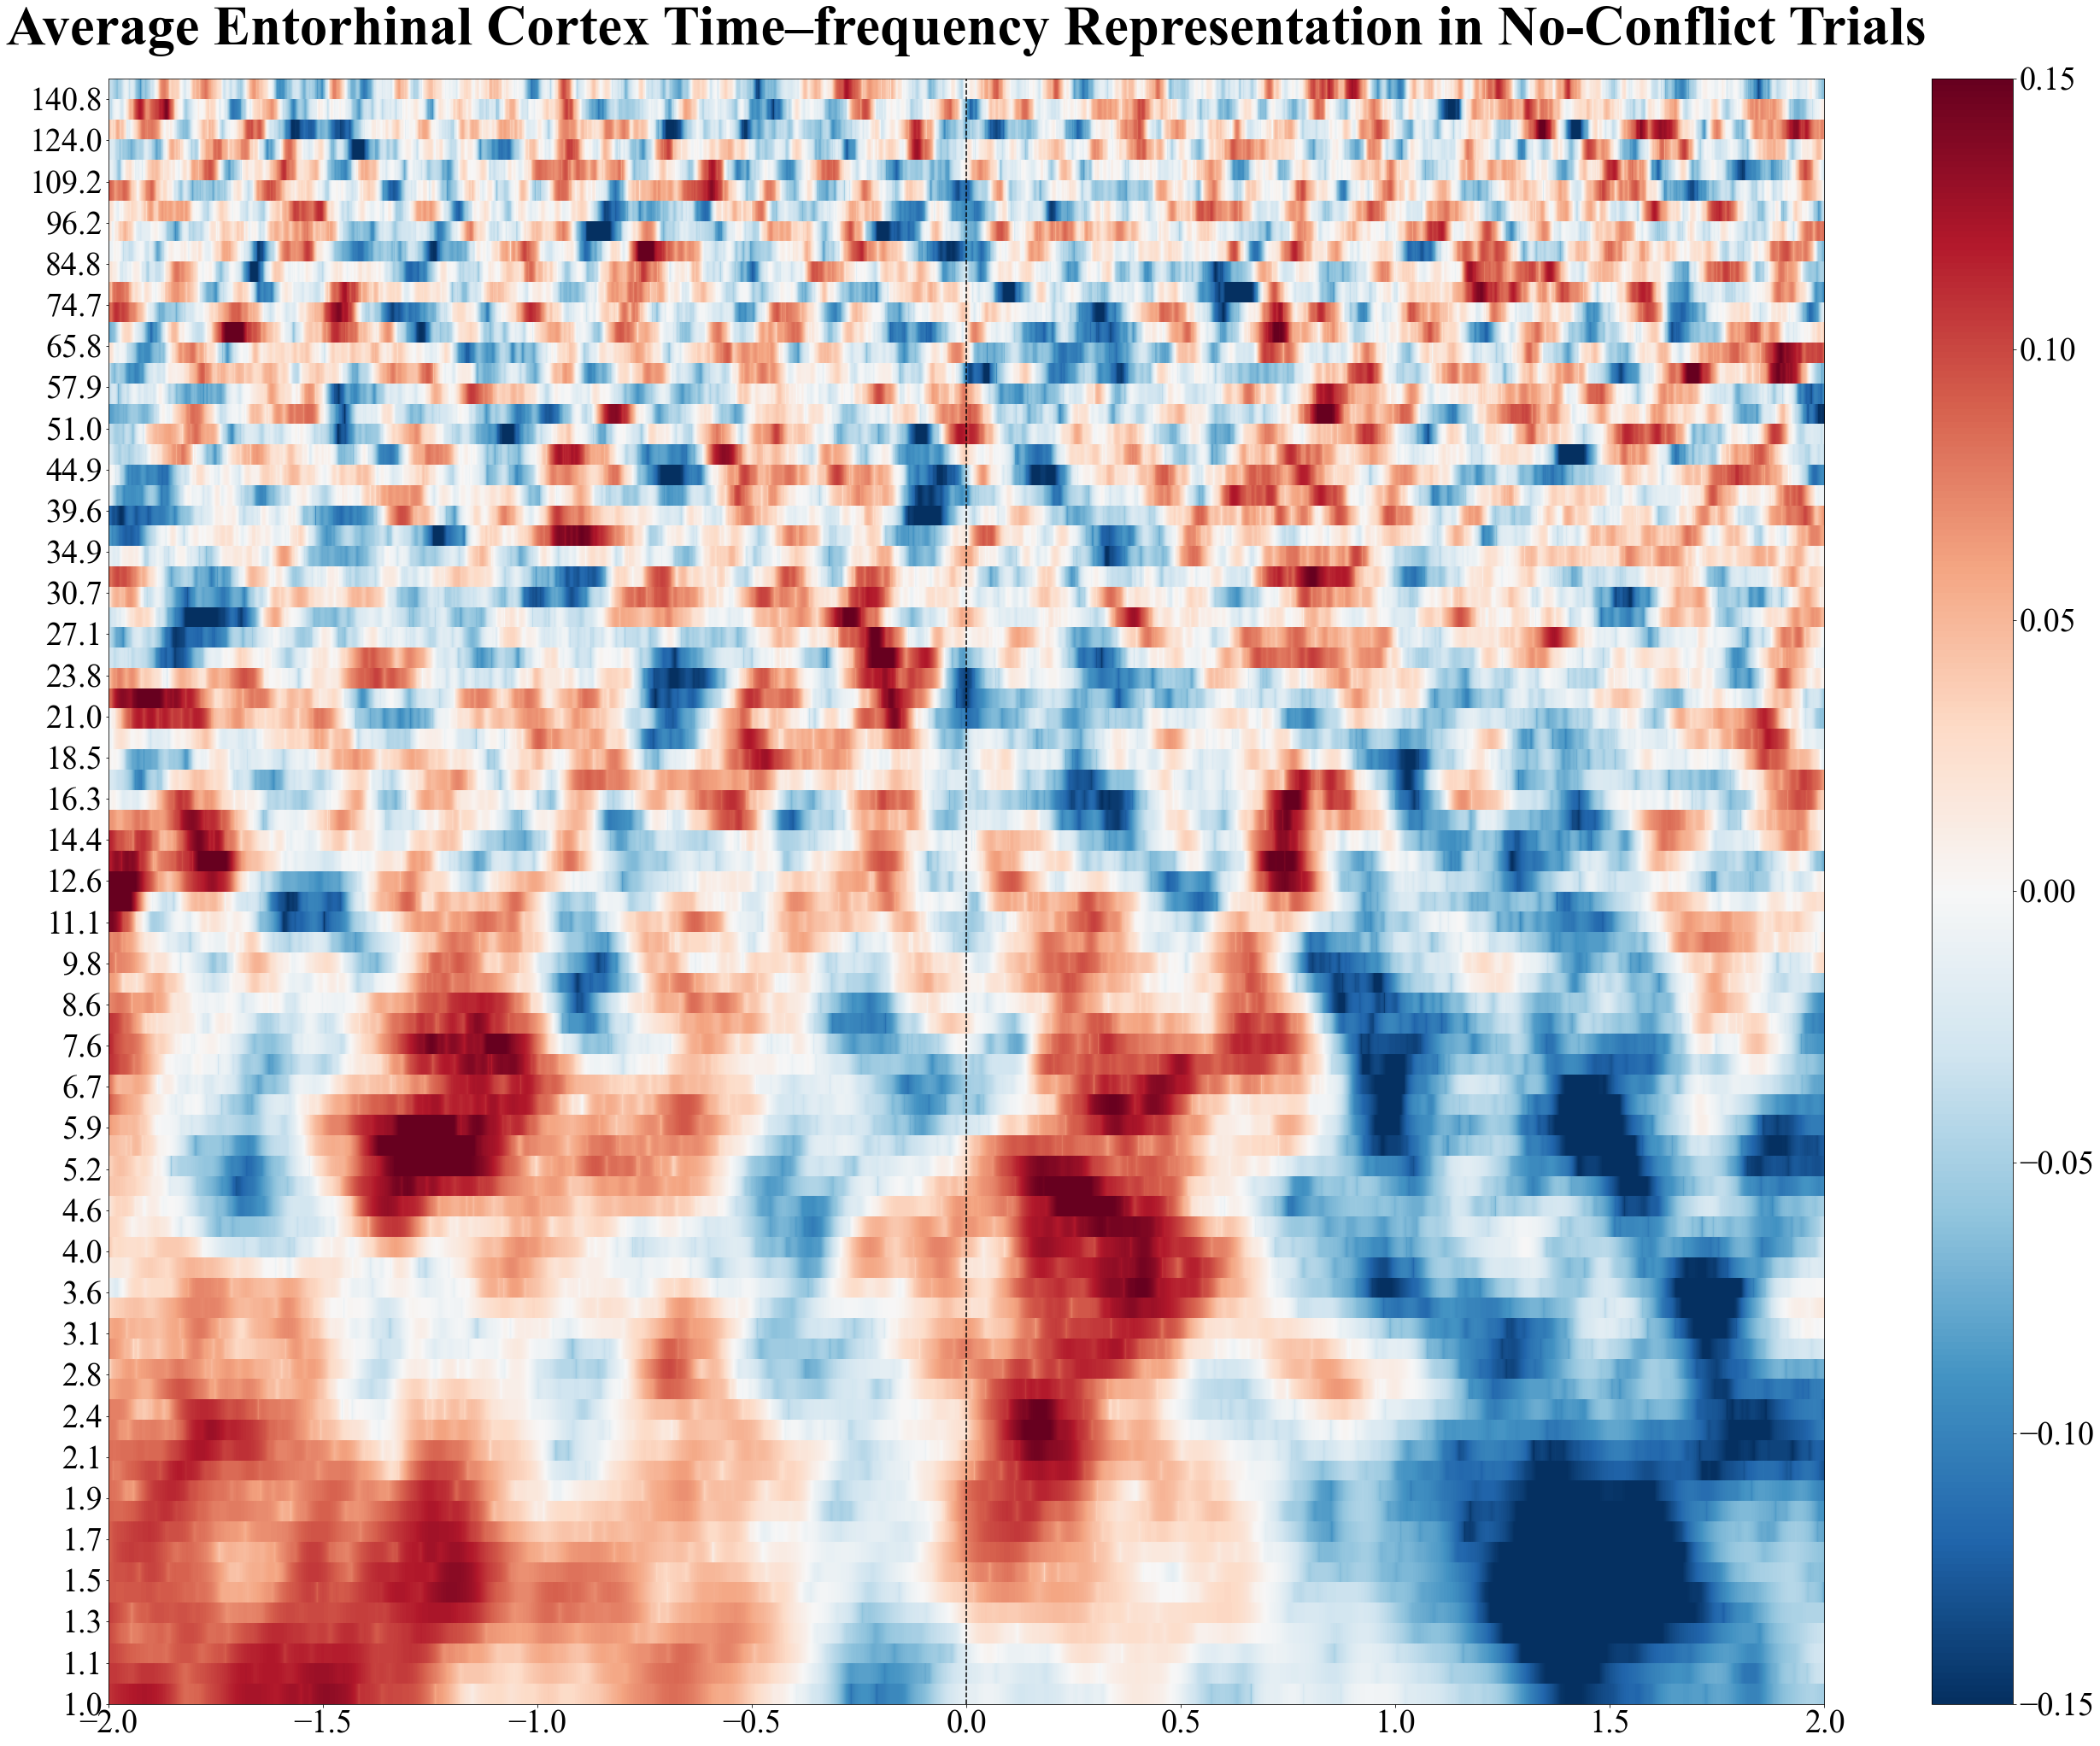

In [115]:
plot_allsub_averages(all_subs_noghost_average_ec, "Average Entorhinal Cortex Time–frequency Representation in No-Conflict Trials", 'average_ec_noconflict_all_subs.png')